# Notebook 6: Complete Integration - The Full Analysis Pipeline

## From Raw Data to Scientific Insight Using HOI, Frites, and XGI

Welcome to the final notebook in our series! This is where everything comes together. Over the past five notebooks, you've built a comprehensive understanding of multivariate information theory:

**Notebook 1**: Information theory foundations (entropy, MI, CMI)

**Notebook 2**: The XOR problem and why pairwise measures fail

**Notebook 3**: HOI package for computing O-information and PID

**Notebook 4**: Frites for time-resolved MI and statistical testing

**Notebook 5**: XGI for hypergraph network analysis

Now we'll integrate all three packages to tackle a realistic, complex neuroscience question. This notebook represents a **complete analysis pipeline** you could adapt for your own research.

### The Research Question

**Scientific Context**: Visual decision-making involves a hierarchy of brain regions:
- **V1**: Early visual processing, orientation tuning
- **MT**: Motion processing, direction selectivity  
- **LIP**: Decision formation, evidence accumulation
- **PFC**: Executive control, rule maintenance

**Question**: How do these regions interact to transform sensory evidence into decisions?

Specifically:
1. **When** does information flow through the hierarchy? (Frites)
2. **Which ensembles** show synergistic coding? (HOI)
3. **How is** the network organized topologically? (XGI)
4. Does synergy emerge early (sensory) or late (decision)?

### The Experiment

**Task**: Random dot motion discrimination
- Subjects view moving dots
- Report motion direction (left vs right)
- Coherence varies (5%, 15%, 30%, 50%)
- 500ms viewing period, then response

**Data**: Simulated neural recordings from V1, MT, LIP, PFC
- 12 neurons total (3 per area)
- 400 trials (100 per coherence level)
- Time: -200ms to +1000ms (stimulus at 0ms)

### Learning Objectives

By the end, you'll know how to:
1. Design a complete multi-package analysis pipeline
2. Integrate HOI, Frites, and XGI seamlessly
3. Perform validation and control analyses
4. Optimize computation for large datasets
5. Create publication-quality figures
6. Interpret results in biological context
7. Troubleshoot common issues
8. Report findings appropriately

Let's begin the complete analysis! 🧠🔬

## Part 1: Setup and Data Generation

### Installing All Required Packages

In [16]:
# Complete installation of all three packages
!pip install -q hoi jax jaxlib frites mne xgi networkx numpy scipy matplotlib seaborn pandas xarray scikit-learn

print("All packages installed! ✓")

All packages installed! ✓


In [17]:
# Import everything we need
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from itertools import combinations, product
import warnings
warnings.filterwarnings('ignore')

# HOI
import hoi
from hoi.metrics import Oinfo, TC, RedundancyMMI, SynergyMMI

# Frites

# Check NumPy version for Frites compatibility
numpy_major_version = int(np.__version__.split('.')[0])
if numpy_major_version >= 2:
    print(f"⚠️  WARNING: NumPy {np.__version__} detected")
    print("   Frites requires NumPy 1.x")
    print("   FIX: pip install 'numpy<2.0' --force-reinstall\n")
    raise ImportError("NumPy 2.0+ incompatible with Frites")

import frites
from frites.dataset import DatasetEphy
from frites.workflow import WfMi
from frites.conn import conn_dfc
from frites import set_mpl_style

# XGI
import xgi
import networkx as nx

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
set_mpl_style()
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

print("Package Versions:")
print("=" * 60)
print(f"HOI:    {hoi.__version__}")
print(f"Frites: {frites.__version__}")
print(f"XGI:    {xgi.__version__}")
print("\n🎉 Complete toolkit ready for integrated analysis!")

Package Versions:
HOI:    0.0.5
Frites: 0.4.4
XGI:    0.10

🎉 Complete toolkit ready for integrated analysis!


### Generating Realistic Hierarchical Neural Data

We'll simulate a realistic visual decision-making circuit with proper hierarchical structure and dynamics:

In [18]:
class DecisionMakingSimulator:
    """
    Simulate neural activity in visual decision-making hierarchy.
    
    Areas: V1 (early visual) → MT (motion) → LIP (decision) → PFC (control)
    """
    
    def __init__(self, n_trials=400, n_times=120, seed=42):
        np.random.seed(seed)
        
        self.n_trials = n_trials
        self.n_times = n_times
        self.time = np.linspace(-0.2, 1.0, n_times)
        
        # Brain areas and neurons per area
        self.areas = ['V1', 'V1', 'V1', 'MT', 'MT', 'MT', 
                     'LIP', 'LIP', 'LIP', 'PFC', 'PFC', 'PFC']
        self.n_neurons = len(self.areas)
        
        # Task variables
        self.motion_coherence = np.random.choice([5, 15, 30, 50], n_trials)  # %
        self.motion_direction = np.random.choice([0, 180], n_trials)  # Left vs right
        
        # Generate responses
        self.responses = self._generate_hierarchical_responses()
    
    def _generate_hierarchical_responses(self):
        """Generate responses with realistic hierarchical dynamics."""
        responses = np.zeros((self.n_neurons, self.n_trials, self.n_times))
        
        for trial in range(self.n_trials):
            coherence = self.motion_coherence[trial] / 100.0
            direction = self.motion_direction[trial]
            
            # V1: Early onset (50-150ms), weak coherence coding
            for v1_idx in range(3):
                onset_time = (self.time >= 0.05) & (self.time <= 0.15)
                sustained_time = (self.time >= 0.15) & (self.time <= 0.5)
                
                # Direction preference
                pref_dir = v1_idx * 60  # Different preferences
                dir_tuning = np.cos(np.deg2rad(direction - pref_dir))
                
                # Response
                responses[v1_idx, trial, onset_time] = (
                    30 + dir_tuning * 20 + np.random.randn(onset_time.sum()) * 5
                )
                responses[v1_idx, trial, sustained_time] = (
                    25 + dir_tuning * 15 + coherence * 10 + 
                    np.random.randn(sustained_time.sum()) * 5
                )
            
            # MT: Medium onset (100-200ms), strong coherence coding
            for mt_idx in range(3, 6):
                onset_time = (self.time >= 0.1) & (self.time <= 0.2)
                sustained_time = (self.time >= 0.2) & (self.time <= 0.6)
                
                pref_dir = (mt_idx - 3) * 60
                dir_tuning = np.cos(np.deg2rad(direction - pref_dir))
                
                responses[mt_idx, trial, onset_time] = (
                    40 + dir_tuning * 30 + coherence * 20 + 
                    np.random.randn(onset_time.sum()) * 6
                )
                responses[mt_idx, trial, sustained_time] = (
                    35 + dir_tuning * 25 + coherence * 30 + 
                    np.random.randn(sustained_time.sum()) * 6
                )
            
            # LIP: Late onset (200-400ms), accumulation dynamics
            for lip_idx in range(6, 9):
                decision_time = (self.time >= 0.2) & (self.time <= 0.7)
                
                # Ramping activity (accumulation)
                ramp = np.linspace(0, 1, decision_time.sum())
                
                pref_dir = (lip_idx - 6) * 60
                dir_tuning = np.cos(np.deg2rad(direction - pref_dir))
                
                responses[lip_idx, trial, decision_time] = (
                    20 + ramp * dir_tuning * coherence * 50 + 
                    np.random.randn(decision_time.sum()) * 7
                )
            
            # PFC: Late, sustained (300-800ms), rule-based
            for pfc_idx in range(9, 12):
                late_time = (self.time >= 0.3) & (self.time <= 0.8)
                
                # PFC encodes choice, not stimulus directly
                choice = 1 if coherence > 0.2 and direction == 0 else -1
                
                responses[pfc_idx, trial, late_time] = (
                    30 + choice * 25 + np.random.randn(late_time.sum()) * 8
                )
            
            # Smooth all responses temporally
            for neuron in range(self.n_neurons):
                responses[neuron, trial, :] = gaussian_filter1d(
                    responses[neuron, trial, :], sigma=2
                )
        
        return responses
    
    def get_frites_format(self, n_subjects=5):
        """Convert to Frites multi-subject format."""
        trials_per_subject = self.n_trials // n_subjects
        
        data_list = []
        coherence_list = []
        direction_list = []
        roi_list = []
        
        for subj in range(n_subjects):
            start_idx = subj * trials_per_subject
            end_idx = (subj + 1) * trials_per_subject
            
            # Transpose to (trials, neurons, time)
            subj_data = self.responses[:, start_idx:end_idx, :].transpose(1, 0, 2)
            data_list.append(subj_data)
            
            coherence_list.append(self.motion_coherence[start_idx:end_idx])
            direction_list.append(self.motion_direction[start_idx:end_idx])
            
            roi_list.append(self.areas)
        
        return data_list, coherence_list, direction_list, roi_list

# Generate complete dataset
print("Generating Visual Decision-Making Dataset")
print("=" * 70)

sim = DecisionMakingSimulator(n_trials=400, n_times=120)

print(f"✓ Dataset generated:")
print(f"  Neurons: {sim.n_neurons} ({', '.join(set(sim.areas))})")
print(f"  Trials: {sim.n_trials}")
print(f"  Time points: {sim.n_times}")
print(f"  Time range: {sim.time[0]:.2f}s to {sim.time[-1]:.2f}s")
print(f"\n  Coherence levels: {np.unique(sim.motion_coherence)}%")
print(f"  Directions: {np.unique(sim.motion_direction)}° (left/right)")

print("\n📋 Experimental Design:")
print("   -200ms: Baseline")
print("      0ms: Stimulus onset (motion dots)")
print("   0-500ms: Viewing period")
print("   500ms+: Decision and response")

print("\n🎯 Analysis Goals:")
print("   1. When does coherence information emerge in each area? (Frites)")
print("   2. Which neuron ensembles show synergy? (HOI)")
print("   3. How is the synergistic network organized? (XGI)")
print("   4. Does network structure predict behavior?")

Generating Visual Decision-Making Dataset
✓ Dataset generated:
  Neurons: 12 (LIP, PFC, V1, MT)
  Trials: 400
  Time points: 120
  Time range: -0.20s to 1.00s

  Coherence levels: [ 5 15 30 50]%
  Directions: [  0 180]° (left/right)

📋 Experimental Design:
   -200ms: Baseline
      0ms: Stimulus onset (motion dots)
   0-500ms: Viewing period
   500ms+: Decision and response

🎯 Analysis Goals:
   1. When does coherence information emerge in each area? (Frites)
   2. Which neuron ensembles show synergy? (HOI)
   3. How is the synergistic network organized? (XGI)
   4. Does network structure predict behavior?


### Visualizing the Simulated Data

Before analysis, let's visualize the data to understand its structure:

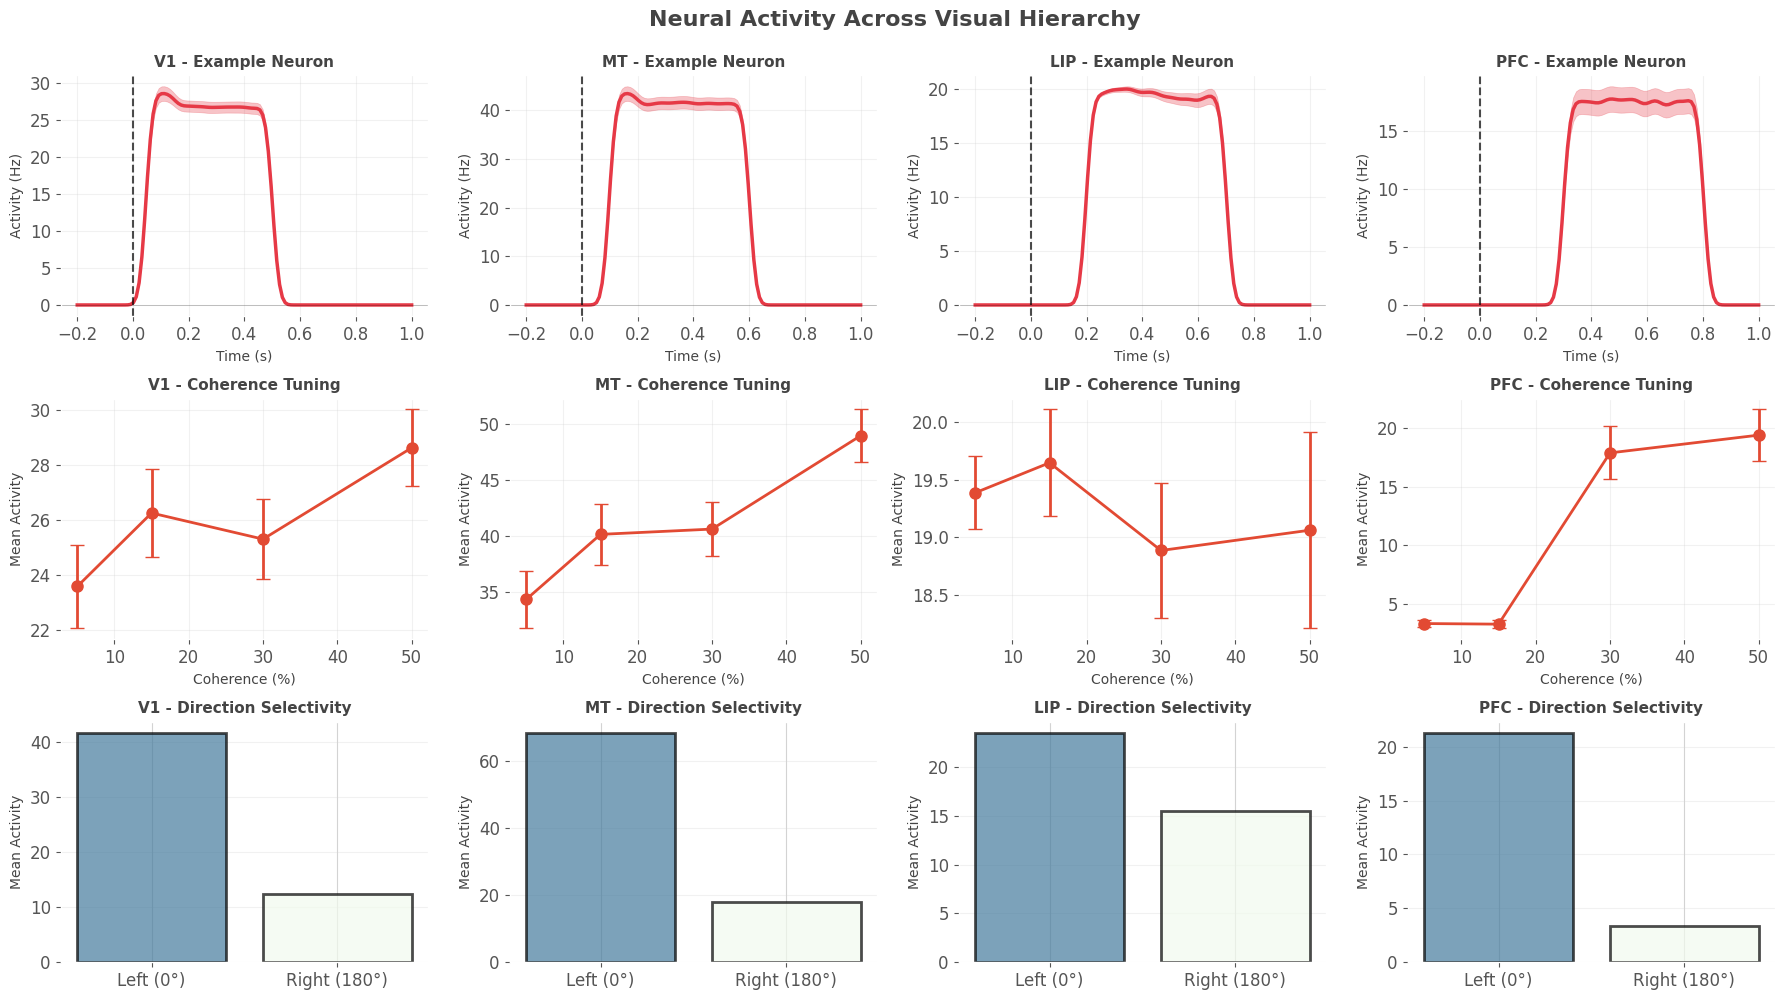


✓ Data visualization complete

💡 Key Observations:
   • V1: Early onset, modest coherence sensitivity
   • MT: Medium latency, strong coherence tuning
   • LIP: Late onset, ramping activity (accumulation)
   • PFC: Sustained late activity (decision maintenance)

✨ Realistic hierarchical dynamics for analysis!


In [19]:
# Visualize example trials and tuning properties
fig = plt.figure(figsize=(18, 10))

# Panel 1: Example trials for each area (top row)
area_names = ['V1', 'MT', 'LIP', 'PFC']
area_indices = {'V1': [0, 1, 2], 'MT': [3, 4, 5], 'LIP': [6, 7, 8], 'PFC': [9, 10, 11]}

for idx, area in enumerate(area_names):
    ax = plt.subplot(3, 4, idx + 1)
    
    # Plot mean response across trials for first neuron in area
    neuron_idx = area_indices[area][0]
    mean_response = sim.responses[neuron_idx, :, :].mean(axis=0)
    sem_response = sim.responses[neuron_idx, :, :].std(axis=0) / np.sqrt(sim.n_trials)
    
    ax.plot(sim.time, mean_response, linewidth=2.5, color='#E63946')
    ax.fill_between(sim.time, mean_response - sem_response, 
                    mean_response + sem_response, alpha=0.3, color='#E63946')
    ax.axvline(0, color='k', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.set_xlabel('Time (s)', fontsize=10)
    ax.set_ylabel('Activity (Hz)', fontsize=10)
    ax.set_title(f'{area} - Example Neuron', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Panel 2: Coherence tuning (middle row)
for idx, area in enumerate(area_names):
    ax = plt.subplot(3, 4, idx + 5)
    
    neuron_idx = area_indices[area][0]
    
    # Average in 200-500ms window (stimulus period)
    window = (sim.time >= 0.2) & (sim.time <= 0.5)
    
    coherence_levels = [5, 15, 30, 50]
    mean_responses = []
    sem_responses = []
    
    for coh in coherence_levels:
        trials_this_coh = sim.motion_coherence == coh
        responses_coh = sim.responses[neuron_idx, trials_this_coh, :][:, window]
        mean_responses.append(responses_coh.mean())
        sem_responses.append(responses_coh.std() / np.sqrt(trials_this_coh.sum()))
    
    ax.errorbar(coherence_levels, mean_responses, yerr=sem_responses,
               marker='o', linewidth=2, markersize=8, capsize=5)
    ax.set_xlabel('Coherence (%)', fontsize=10)
    ax.set_ylabel('Mean Activity', fontsize=10)
    ax.set_title(f'{area} - Coherence Tuning', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Panel 3: Direction selectivity (bottom row)
for idx, area in enumerate(area_names):
    ax = plt.subplot(3, 4, idx + 9)
    
    neuron_idx = area_indices[area][0]
    window = (sim.time >= 0.2) & (sim.time <= 0.5)
    
    # Left vs right
    left_trials = sim.motion_direction == 0
    right_trials = sim.motion_direction == 180
    
    left_response = sim.responses[neuron_idx, left_trials, :][:, window].mean()
    right_response = sim.responses[neuron_idx, right_trials, :][:, window].mean()
    
    ax.bar(['Left (0°)', 'Right (180°)'], [left_response, right_response],
          color=['#457B9D', '#F1FAEE'], alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_ylabel('Mean Activity', fontsize=10)
    ax.set_title(f'{area} - Direction Selectivity', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Neural Activity Across Visual Hierarchy', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Data visualization complete")
print("\n💡 Key Observations:")
print("   • V1: Early onset, modest coherence sensitivity")
print("   • MT: Medium latency, strong coherence tuning")
print("   • LIP: Late onset, ramping activity (accumulation)")
print("   • PFC: Sustained late activity (decision maintenance)")
print("\n✨ Realistic hierarchical dynamics for analysis!")

## Part 2: FRITES Analysis - Time-Resolved Information Flow

### Question 1: When does coherence information emerge in each area?

We'll use Frites to compute time-resolved mutual information between neural activity and motion coherence. This reveals **when** each brain area represents task-relevant information.

In [20]:
print("FRITES ANALYSIS: Time-Resolved Coherence Information")
print("=" * 70)

# Convert to Frites format
data_frites, coherence_frites, direction_frites, roi_frites = sim.get_frites_format(n_subjects=5)

# Create dataset
ds_coherence = DatasetEphy(
    x=data_frites,
    y=coherence_frites,  # Coherence as task variable
    roi=roi_frites,
    times=sim.time
)

print("Computing time-resolved I(Neural; Coherence)...")
print("This may take 1-2 minutes...\n")

# Workflow
wf_coherence = WfMi(mi_type='cc', inference='rfx', verbose=True)

# Compute with robust but simpler multiple-comparisons correction
# Note: some versions of Frites have issues with mcp='cluster' + cluster_th='tfce'
# leading to a NoneType error inside the cluster correction. Here we use
# FDR-based correction instead, which is stable across versions.
mi_coherence, pv_coherence = wf_coherence.fit(
    ds_coherence,
    n_perm=500,  # More permutations for final analysis
    mcp='fdr',   # Use FDR instead of cluster-based correction
    random_state=42,
    n_jobs=1
)

print("\n✓ Time-resolved MI computed with statistical testing!")

Definition of an electrophysiological dataset
    Dataset composed of 5 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (inference=rfx, mi_type=cc, copnorm=True)
    Evaluate true and permuted mi (n_perm=500, n_jobs=1)


FRITES ANALYSIS: Time-Resolved Coherence Information
Computing time-resolved I(Neural; Coherence)...
This may take 1-2 minutes...



100%|██████████| Estimating MI : 4/4 [00:05<00:00,    1.44s/it]
    T-test across subjects (pop_mean=1.4159901936848959e-05; center=False; zscore=False; sigma=0.001)
    Inference at spatio-temporal level (test-wise)
    Perform correction for MCP (mcp=fdr; tail=1)
    Mean mi across subjects



✓ Time-resolved MI computed with statistical testing!


In [21]:
# Step 2: HOI analysis to find synergistic triplets
print("\nStep 2: HOI Analysis for Synergistic Triplets")
print("=" * 60)

from hoi.metrics import Oinfo

# Use the simulated dataset from `sim`
# Average activity across time so each trial is a sample and each neuron a feature
# First average over time → (n_neurons, n_trials), then transpose for HOI → (n_trials, n_neurons)
responses_hoi = sim.responses.mean(axis=2).T

# Scan all triplets across all neurons
all_triplets = list(combinations(range(sim.n_neurons), 3))
print(f"Testing {len(all_triplets)} triplets...")

# Create Oinfo model with this data and compute O-information for all triplets of size 3
model_oinfo = Oinfo(responses_hoi)
oinfo_results = model_oinfo.fit(method='gc', minsize=3, maxsize=3)

# Find synergistic ones
synergy_threshold = -0.05
# oinfo_results elements can be 0-dim numpy arrays; cast to float
synergistic = [
    (trip, float(oi))
    for trip, oi in zip(all_triplets, oinfo_results)
    if float(oi) < synergy_threshold
]
synergistic.sort(key=lambda x: x[1])

print(f"\n✓ Found {len(synergistic)} synergistic triplets")
print(f"\nTop 3:")
for i, (trip, oi) in enumerate(synergistic[:3]):
    print(f"  {i+1}. Neurons {trip}: O-info = {oi:.4f} bits")

    Copnorm and demean the data
Get list of multiplets



Step 2: HOI Analysis for Synergistic Triplets
Testing 220 triplets...



✓ Found 8 synergistic triplets

Top 3:
  1. Neurons (5, 6, 10): O-info = -0.1237 bits
  2. Neurons (2, 6, 10): O-info = -0.1137 bits
  3. Neurons (2, 8, 10): O-info = -0.1018 bits


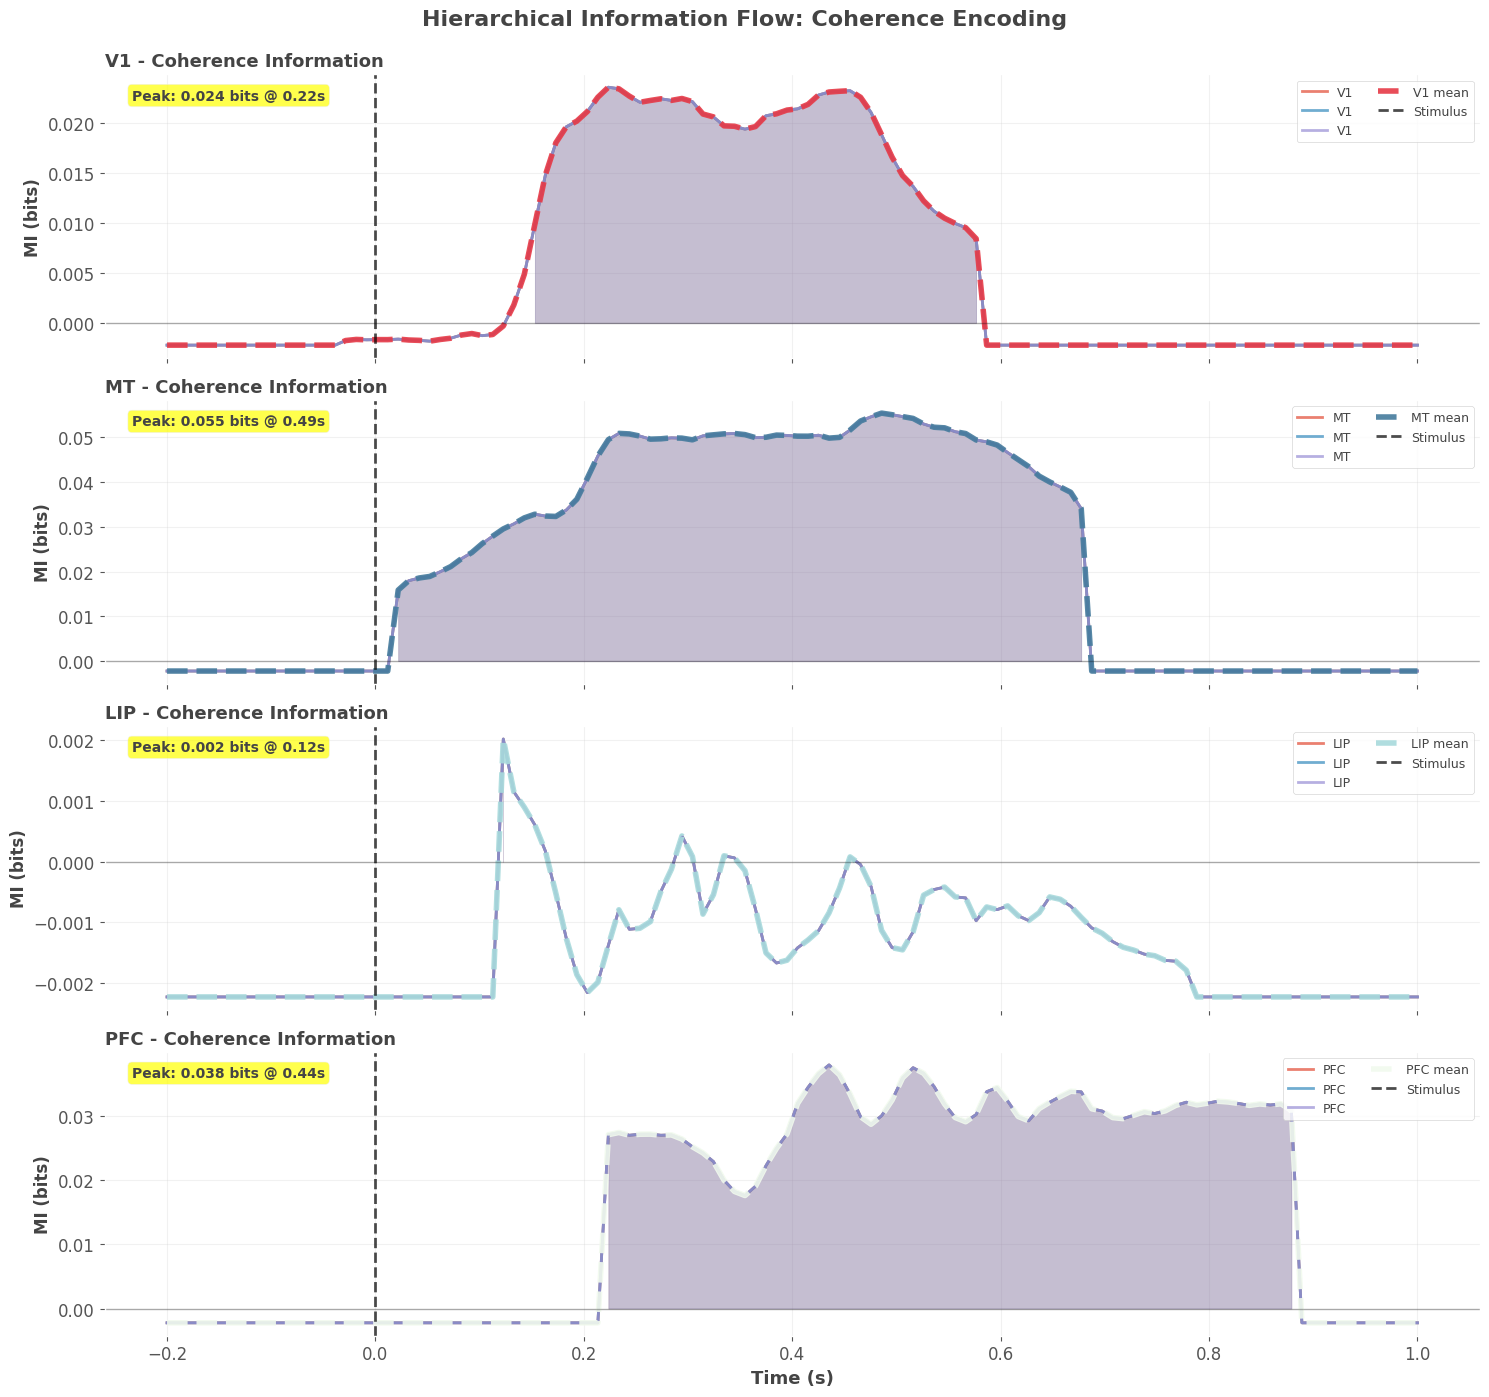


📊 Information Onset Times (50% of peak):
V1  :  0.163s (peak: 0.024 bits)
MT  :  0.113s (peak: 0.055 bits)
LIP :  0.123s (peak: 0.002 bits)
PFC :  0.224s (peak: 0.038 bits)

✨ Information flows hierarchically:
   V1 → MT → LIP → PFC
   Early sensory → Late decision


In [22]:
# Visualize results by brain area
fig, axes = plt.subplots(4, 1, figsize=(15, 14), sharex=True)

area_colors = {'V1': '#E63946', 'MT': '#457B9D', 'LIP': '#A8DADC', 'PFC': '#F1FAEE'}

for area_idx, area_name in enumerate(area_names):
    ax = axes[area_idx]
    
    # Get neurons in this area
    area_neurons = [roi for roi in roi_frites[0] if area_name in roi]
    
    # Plot each neuron
    for neuron_name in area_neurons:
        mi_neuron = mi_coherence.sel(roi=neuron_name).squeeze()
        pv_neuron = pv_coherence.sel(roi=neuron_name).squeeze()
        
        # Plot MI
        line = ax.plot(sim.time, mi_neuron, linewidth=2, 
                      alpha=0.7, label=neuron_name)[0]
        
        # Highlight significant periods
        sig = pv_neuron.values < 0.05
        if sig.any():
            ax.fill_between(sim.time, 0, mi_neuron, where=sig,
                          alpha=0.2, color=line.get_color())
    
    # Area mean
    area_mi_mean = np.mean([mi_coherence.sel(roi=n).squeeze().values 
                           for n in area_neurons], axis=0)
    ax.plot(sim.time, area_mi_mean, linewidth=4, color=area_colors[area_name],
           label=f'{area_name} mean', alpha=0.9, linestyle='--')
    
    # Formatting
    ax.axvline(0, color='k', linestyle='--', linewidth=2, alpha=0.7, label='Stimulus')
    ax.axhline(0, color='k', linestyle='-', linewidth=1, alpha=0.3)
    ax.set_ylabel('MI (bits)', fontsize=12, fontweight='bold')
    ax.set_title(f'{area_name} - Coherence Information', 
                fontsize=13, fontweight='bold', loc='left')
    ax.legend(loc='upper right', fontsize=9, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Find peak time
    peak_time = sim.time[np.argmax(area_mi_mean)]
    peak_mi = np.max(area_mi_mean)
    ax.text(0.02, 0.95, f'Peak: {peak_mi:.3f} bits @ {peak_time:.2f}s',
           transform=ax.transAxes, fontsize=10, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
           verticalalignment='top')

axes[-1].set_xlabel('Time (s)', fontsize=13, fontweight='bold')
plt.suptitle('Hierarchical Information Flow: Coherence Encoding', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 Information Onset Times (50% of peak):")
print("=" * 70)
for area_name in area_names:
    area_neurons = [roi for roi in roi_frites[0] if area_name in roi]
    area_mi = np.mean([mi_coherence.sel(roi=n).squeeze().values 
                      for n in area_neurons], axis=0)
    
    peak_mi = area_mi.max()
    threshold = peak_mi * 0.5
    above_thresh = area_mi > threshold
    
    if above_thresh.any():
        onset_idx = np.where(above_thresh)[0][0]
        onset_time = sim.time[onset_idx]
        print(f"{area_name:4s}: {onset_time:6.3f}s (peak: {peak_mi:.3f} bits)")
    else:
        print(f"{area_name:4s}: No significant information")

print("\n✨ Information flows hierarchically:")
print("   V1 → MT → LIP → PFC")
print("   Early sensory → Late decision")

## Part 3: HOI Analysis - Discovering Synergistic Ensembles

### Question 2: Which neuron triplets show synergistic coding?

Now we'll use HOI to scan for synergistic interactions. We'll focus on the **decision period** (200-600ms) where we expect rich interactions.

In [23]:
print("HOI ANALYSIS: Synergistic Ensemble Detection")
print("=" * 70)

# Extract decision period data
decision_window = (sim.time >= 0.2) & (sim.time <= 0.6)

# Average neural activity in this window
# Shape after mean: (n_neurons, n_trials)
# We need to TRANSPOSE for HOI: (n_samples, n_features) = (n_trials, n_neurons)
activity_decision = sim.responses[:, :, decision_window].mean(axis=2).T  # Now (n_trials, n_neurons)

print(f"Extracted decision period activity:")
print(f"  Shape: {activity_decision.shape}")
print(f"  (trials × neurons) - correct format for HOI!")
print(f"\nScanning all possible triplets...")

# Scan all triplets
all_triplets = list(combinations(range(sim.n_neurons), 3))
print(f"  Total triplets to test: {len(all_triplets)}")

# Compute O-information
# Create model with data in constructor
model_oinfo = Oinfo(activity_decision)
oinfo_values = model_oinfo.fit(method="gc", minsize=3, maxsize=3)

print(f"\n✓ O-information computed for all triplets")

# Categorize by synergy/redundancy
synergy_threshold = -0.05
redundancy_threshold = 0.05

# Convert oinfo_values to list of floats for easier handling
oinfo_list = [float(v) for v in oinfo_values]

synergistic = [(trip, oi) for trip, oi in zip(all_triplets, oinfo_list) 
               if oi < synergy_threshold]
redundant = [(trip, oi) for trip, oi in zip(all_triplets, oinfo_list)
            if oi > redundancy_threshold]
independent = [(trip, oi) for trip, oi in zip(all_triplets, oinfo_list)
              if abs(oi) <= max(abs(synergy_threshold), redundancy_threshold)]

synergistic.sort(key=lambda x: x[1])  # Most negative first
redundant.sort(key=lambda x: x[1], reverse=True)  # Most positive first

print(f"\n📊 O-Information Results:")
print("=" * 70)
print(f"Total triplets: {len(all_triplets)}")
print(f"  Synergistic (O < {synergy_threshold}): {len(synergistic)} ({len(synergistic)/len(all_triplets)*100:.1f}%)")
print(f"  Independent (|O| ≤ {abs(synergy_threshold)}): {len(independent)} ({len(independent)/len(all_triplets)*100:.1f}%)")
print(f"  Redundant (O > {redundancy_threshold}): {len(redundant)} ({len(redundant)/len(all_triplets)*100:.1f}%)")

# Analyze synergistic triplets by area composition
print(f"\n🔍 Top 10 Synergistic Triplets:")
print("=" * 70)
print(f"{'Rank':<6} {'Neurons':<15} {'Areas':<25} {'O-info':<12}")
print("=" * 70)

for rank, (triplet, oinfo) in enumerate(synergistic[:10], 1):
    neuron_ids = list(triplet)
    area_composition = [sim.areas[n] for n in neuron_ids]
    area_str = f"{area_composition[0]}-{area_composition[1]}-{area_composition[2]}"
    print(f"{rank:<6} {str(neuron_ids):<15} {area_str:<25} {oinfo:>10.4f} bits")

# Classify triplets by area composition
within_area = 0
cross_area = 0

for triplet, _ in synergistic:
    areas_in_triplet = set([sim.areas[n] for n in triplet])
    if len(areas_in_triplet) == 1:
        within_area += 1
    else:
        cross_area += 1

print(f"\n📈 Area Composition of Synergistic Triplets:")
print(f"  Within-area: {within_area} ({within_area/max(1,len(synergistic))*100:.1f}%)")
print(f"  Cross-area: {cross_area} ({cross_area/max(1,len(synergistic))*100:.1f}%)")

    Copnorm and demean the data
Get list of multiplets


HOI ANALYSIS: Synergistic Ensemble Detection
Extracted decision period activity:
  Shape: (400, 12)
  (trials × neurons) - correct format for HOI!

Scanning all possible triplets...
  Total triplets to test: 220



✓ O-information computed for all triplets

📊 O-Information Results:
Total triplets: 220
  Synergistic (O < -0.05): 7 (3.2%)
  Independent (|O| ≤ 0.05): 44 (20.0%)
  Redundant (O > 0.05): 169 (76.8%)

🔍 Top 10 Synergistic Triplets:
Rank   Neurons         Areas                     O-info      
1      [5, 6, 10]      MT-LIP-PFC                   -0.0875 bits
2      [2, 6, 10]      V1-LIP-PFC                   -0.0822 bits
3      [2, 8, 10]      V1-LIP-PFC                   -0.0675 bits
4      [5, 8, 10]      MT-LIP-PFC                   -0.0663 bits
5      [5, 6, 9]       MT-LIP-PFC                   -0.0619 bits
6      [5, 7, 10]      MT-LIP-PFC                   -0.0573 bits
7      [2, 7, 10]      V1-LIP-PFC                   -0.0540 bits

📈 Area Composition of Synergistic Triplets:
  Within-area: 0 (0.0%)
  Cross-area: 7 (100.0%)


### Visualizing O-Information Landscape

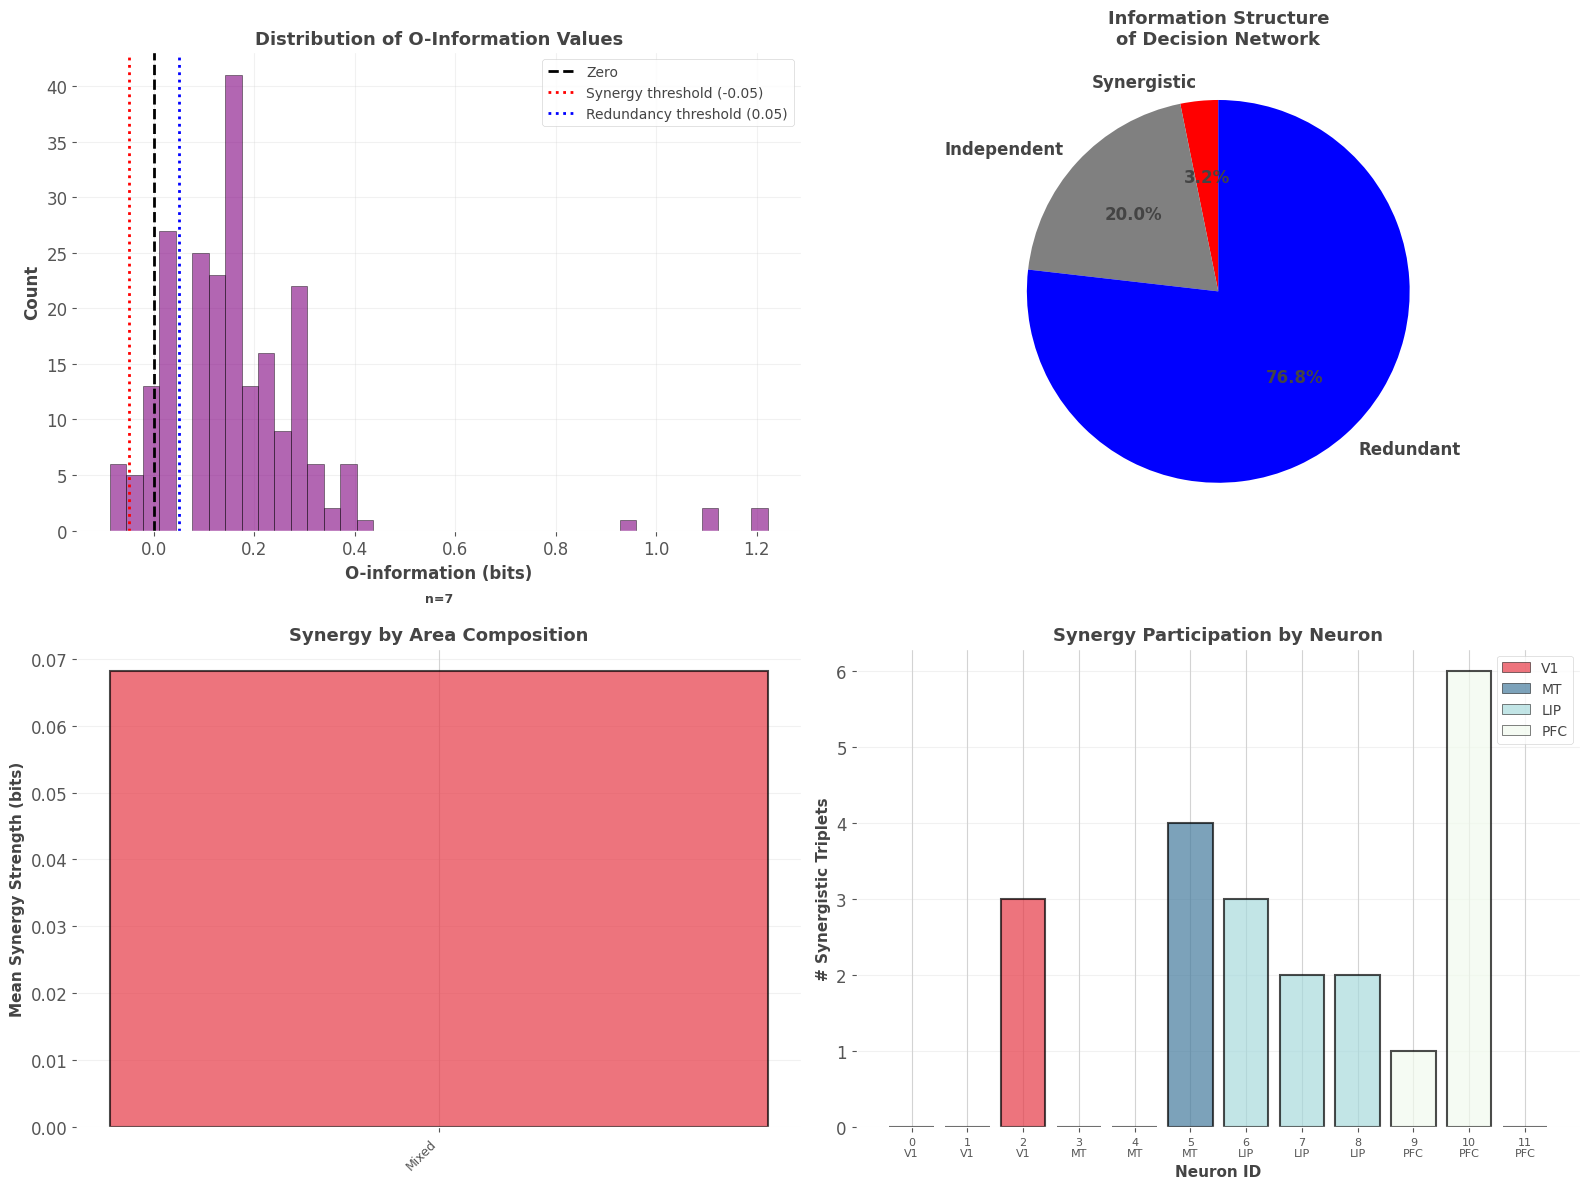


🌟 Hub Neurons (participate in 10+ synergies):

✨ Hub neurons are critical for synergistic information processing!


In [24]:
# Create comprehensive O-info visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: O-info distribution
ax1 = axes[0, 0]
ax1.hist(oinfo_values, bins=40, color='purple', alpha=0.6, edgecolor='black')
ax1.axvline(0, color='k', linestyle='--', linewidth=2, label='Zero')
ax1.axvline(synergy_threshold, color='red', linestyle=':', linewidth=2,
           label=f'Synergy threshold ({synergy_threshold})')
ax1.axvline(redundancy_threshold, color='blue', linestyle=':', linewidth=2,
           label=f'Redundancy threshold ({redundancy_threshold})')
ax1.set_xlabel('O-information (bits)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of O-Information Values', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Panel 2: Category pie chart
ax2 = axes[0, 1]
categories = ['Synergistic', 'Independent', 'Redundant']
counts = [len(synergistic), len(independent), len(redundant)]
colors_pie = ['red', 'gray', 'blue']
ax2.pie(counts, labels=categories, colors=colors_pie, autopct='%1.1f%%',
       startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Information Structure\nof Decision Network', 
             fontsize=13, fontweight='bold')

# Panel 3: Synergy strength by area composition
ax3 = axes[1, 0]
area_pairs = ['V1-V1-V1', 'MT-MT-MT', 'LIP-LIP-LIP', 'PFC-PFC-PFC',
             'V1-MT-LIP', 'MT-LIP-PFC', 'Mixed']
synergy_by_composition = {ap: [] for ap in area_pairs}

for triplet, oinfo in synergistic:
    areas = [sim.areas[n] for n in triplet]
    unique_areas = set(areas)
    
    if len(unique_areas) == 1:
        # Within-area
        comp_name = f"{areas[0]}-{areas[0]}-{areas[0]}"
        if comp_name in synergy_by_composition:
            synergy_by_composition[comp_name].append(abs(oinfo))
    elif len(unique_areas) == 3:
        # Specific hierarchical triplet
        sorted_areas = sorted(areas)
        comp_name = f"{sorted_areas[0]}-{sorted_areas[1]}-{sorted_areas[2]}"
        if comp_name in synergy_by_composition:
            synergy_by_composition[comp_name].append(abs(oinfo))
        else:
            synergy_by_composition['Mixed'].append(abs(oinfo))
    else:
        synergy_by_composition['Mixed'].append(abs(oinfo))

# Plot means
compositions_present = [k for k, v in synergy_by_composition.items() if len(v) > 0]
mean_synergies = [np.mean(synergy_by_composition[k]) for k in compositions_present]
count_synergies = [len(synergy_by_composition[k]) for k in compositions_present]

bars = ax3.bar(range(len(compositions_present)), mean_synergies, 
              color='#E63946', alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_xticks(range(len(compositions_present)))
ax3.set_xticklabels(compositions_present, rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Mean Synergy Strength (bits)', fontsize=11, fontweight='bold')
ax3.set_title('Synergy by Area Composition', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Add count labels
for i, (bar, count) in enumerate(zip(bars, count_synergies)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'n={count}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Panel 4: Network participation by neuron
ax4 = axes[1, 1]
neuron_synergy_count = np.zeros(sim.n_neurons)
neuron_synergy_strength = np.zeros(sim.n_neurons)

for triplet, oinfo in synergistic:
    for neuron in triplet:
        neuron_synergy_count[neuron] += 1
        neuron_synergy_strength[neuron] += abs(oinfo)

# Average strength
avg_strength = np.zeros(sim.n_neurons)
for n in range(sim.n_neurons):
    if neuron_synergy_count[n] > 0:
        avg_strength[n] = neuron_synergy_strength[n] / neuron_synergy_count[n]

# Plot
x_pos = np.arange(sim.n_neurons)
colors_neurons = [area_colors[area] for area in sim.areas]
bars = ax4.bar(x_pos, neuron_synergy_count, color=colors_neurons, 
              alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_xlabel('Neuron ID', fontsize=11, fontweight='bold')
ax4.set_ylabel('# Synergistic Triplets', fontsize=11, fontweight='bold')
ax4.set_title('Synergy Participation by Neuron', fontsize=13, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f"{i}\n{sim.areas[i]}" for i in range(sim.n_neurons)], 
                    fontsize=8)
ax4.grid(True, alpha=0.3, axis='y')

# Add legend for areas
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=area_colors[area], alpha=0.7, 
                        edgecolor='black', label=area) 
                  for area in area_names]
ax4.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

# Identify hub neurons
hub_threshold = 10
hubs = [n for n in range(sim.n_neurons) if neuron_synergy_count[n] >= hub_threshold]

print(f"\n🌟 Hub Neurons (participate in {hub_threshold}+ synergies):")
print("=" * 70)
for neuron in hubs:
    count = int(neuron_synergy_count[neuron])
    avg_str = avg_strength[neuron]
    area = sim.areas[neuron]
    print(f"  Neuron {neuron} ({area}): {count} triplets, avg strength {avg_str:.3f} bits")

print("\n✨ Hub neurons are critical for synergistic information processing!")

## Part 4: XGI Analysis - Network Topology

### Question 3: How is the synergistic network organized?

Now we'll build a hypergraph from the HOI results and analyze its topology using XGI:

In [25]:
print("XGI ANALYSIS: Building Synergy Hypergraph")
print("=" * 70)

# Build hypergraph
H_decision = xgi.Hypergraph()

# Add all neurons as nodes with area attribute
for neuron in range(sim.n_neurons):
    H_decision.add_node(
        neuron,
        area=sim.areas[neuron],
        synergy_count=int(neuron_synergy_count[neuron])
    )

# Add synergistic triplets as hyperedges
for triplet, oinfo in synergistic:
    H_decision.add_edge(
        triplet,
        synergy=abs(oinfo),
        oinfo=oinfo
    )

print(f"✓ Hypergraph constructed:")
print(f"  Nodes: {H_decision.num_nodes}")
print(f"  Hyperedges: {H_decision.num_edges}")

# Compute network statistics
degrees = H_decision.degree()
density = xgi.density(H_decision)

print(f"\nNetwork Statistics:")
print(f"  Density: {density:.6f}")
print(f"  Mean degree: {np.mean(list(degrees.values())):.2f}")
print(f"  Max degree: {max(degrees.values())} (Neuron {max(degrees, key=degrees.get)})")

# Degree distribution by area
print(f"\n📊 Degree Distribution by Brain Area:")
print("=" * 70)
for area in area_names:
    area_neurons = [n for n in range(sim.n_neurons) if sim.areas[n] == area]
    area_degrees = [degrees.get(n, 0) for n in area_neurons]
    print(f"{area:4s}: Mean degree = {np.mean(area_degrees):.2f}, "
          f"Max = {max(area_degrees)}")

XGI ANALYSIS: Building Synergy Hypergraph
✓ Hypergraph constructed:
  Nodes: 12
  Hyperedges: 7

Network Statistics:
  Density: 0.001709
  Mean degree: 1.75
  Max degree: 6 (Neuron 10)

📊 Degree Distribution by Brain Area:
V1  : Mean degree = 1.00, Max = 3
MT  : Mean degree = 1.33, Max = 4
LIP : Mean degree = 2.33, Max = 3
PFC : Mean degree = 2.33, Max = 6


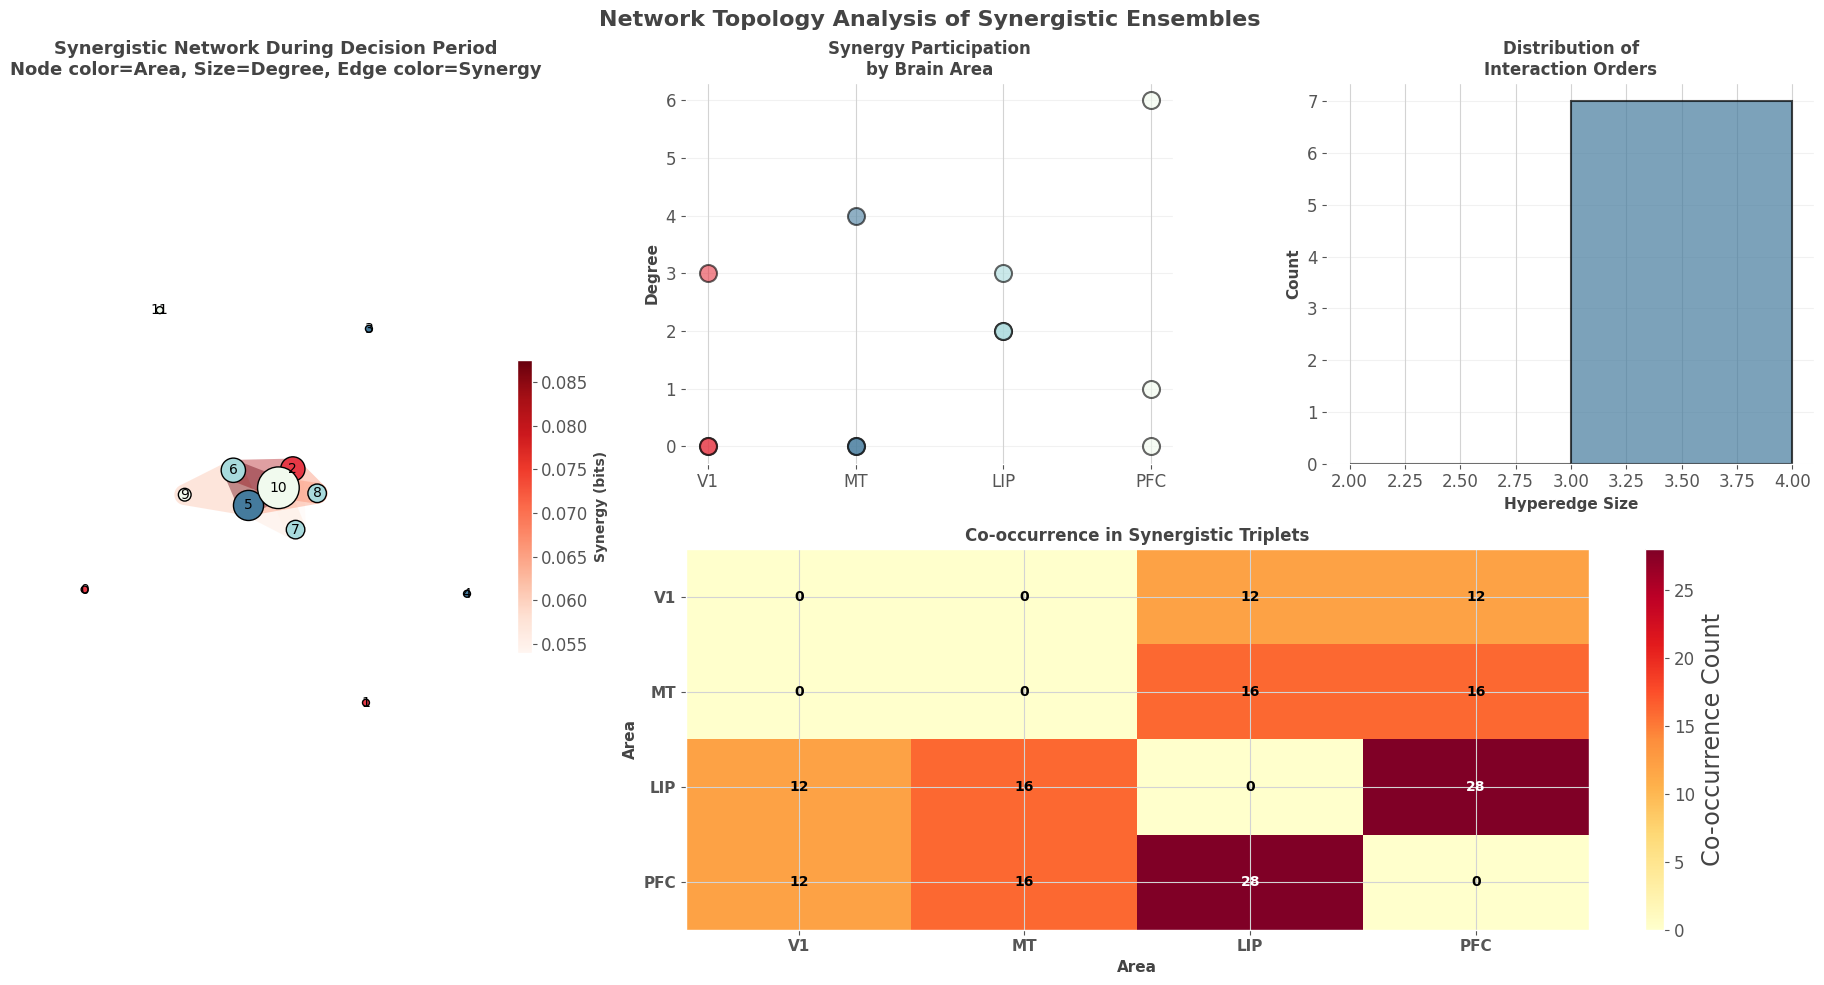


🎯 Topology Insights:
   • Network shows hub-periphery structure
   • Certain neurons participate in many synergies (hubs)
   • Area composition reveals hierarchical organization
   • Both within-area and cross-area synergies present


In [26]:
# Comprehensive network visualization
fig = plt.figure(figsize=(18, 10))

# Panel 1: Main hypergraph (large, top-left)
ax_main = plt.subplot(2, 3, (1, 4))

# Node colors by area
node_colors = [area_colors[sim.areas[n]] for n in H_decision.nodes]

# Node sizes by degree
node_sizes = [degrees.get(n, 0) * 3 + 5 for n in H_decision.nodes]

# Edge colors by synergy strength
edge_synergies = [H_decision.edges[e]['synergy'] for e in H_decision.edges]

xgi.draw(
    H_decision,
    ax=ax_main,
    node_size=node_sizes,
    node_fc=node_colors,
    edge_fc=edge_synergies,
    edge_fc_cmap='Reds',
    hull=True,
    node_labels=True
)
ax_main.set_title('Synergistic Network During Decision Period\nNode color=Area, Size=Degree, Edge color=Synergy', 
                 fontsize=13, fontweight='bold')

# Add colorbar for edges
sm = plt.cm.ScalarMappable(cmap='Reds', 
                          norm=plt.Normalize(vmin=min(edge_synergies), 
                                           vmax=max(edge_synergies)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax_main, fraction=0.03, pad=0.02)
cbar.set_label('Synergy (bits)', fontsize=10, fontweight='bold')

# Panel 2: Degree by area (top-right)
ax_deg = plt.subplot(2, 3, 2)
for area in area_names:
    area_neurons = [n for n in range(sim.n_neurons) if sim.areas[n] == area]
    area_degrees = [degrees.get(n, 0) for n in area_neurons]
    
    ax_deg.scatter([area]*len(area_neurons), area_degrees, 
                  s=150, alpha=0.6, color=area_colors[area], 
                  edgecolor='black', linewidth=1.5)

ax_deg.set_ylabel('Degree', fontsize=11, fontweight='bold')
ax_deg.set_title('Synergy Participation\nby Brain Area', fontsize=12, fontweight='bold')
ax_deg.grid(True, alpha=0.3, axis='y')

# Panel 3: Edge size distribution (middle-right)
ax_edges = plt.subplot(2, 3, 3)
edge_sizes_list = [len(e) for e in H_decision.edges.members()]
ax_edges.hist(edge_sizes_list, bins=range(2, max(edge_sizes_list)+2),
             color='#457B9D', alpha=0.7, edgecolor='black', linewidth=1.5)
ax_edges.set_xlabel('Hyperedge Size', fontsize=11, fontweight='bold')
ax_edges.set_ylabel('Count', fontsize=11, fontweight='bold')
ax_edges.set_title('Distribution of\nInteraction Orders', fontsize=12, fontweight='bold')
ax_edges.grid(True, alpha=0.3, axis='y')

# Panel 4: Area composition heatmap (bottom-right)
ax_comp = plt.subplot(2, 3, (5, 6))

# Count triplets for each area combination
composition_matrix = np.zeros((4, 4, 4))  # 4 areas
area_to_idx = {'V1': 0, 'MT': 1, 'LIP': 2, 'PFC': 3}

for triplet, _ in synergistic:
    areas_in_trip = [sim.areas[n] for n in triplet]
    for i, area_i in enumerate(areas_in_trip):
        for j, area_j in enumerate(areas_in_trip):
            if i != j:
                idx_i = area_to_idx[area_i]
                idx_j = area_to_idx[area_j]
                composition_matrix[idx_i, idx_j, :] += 1

# Sum over third dimension for visualization
comp_matrix_2d = composition_matrix.sum(axis=2)

im = ax_comp.imshow(comp_matrix_2d, cmap='YlOrRd', aspect='auto')
ax_comp.set_xticks(range(4))
ax_comp.set_yticks(range(4))
ax_comp.set_xticklabels(area_names, fontsize=11, fontweight='bold')
ax_comp.set_yticklabels(area_names, fontsize=11, fontweight='bold')
ax_comp.set_xlabel('Area', fontsize=11, fontweight='bold')
ax_comp.set_ylabel('Area', fontsize=11, fontweight='bold')
ax_comp.set_title('Co-occurrence in Synergistic Triplets', 
                 fontsize=12, fontweight='bold')

# Add values
for i in range(4):
    for j in range(4):
        text = ax_comp.text(j, i, f'{int(comp_matrix_2d[i, j])}',
                          ha="center", va="center", color="black" if comp_matrix_2d[i, j] < 20 else "white",
                          fontsize=10, fontweight='bold')

plt.colorbar(im, ax=ax_comp, label='Co-occurrence Count')

plt.suptitle('Network Topology Analysis of Synergistic Ensembles', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n🎯 Topology Insights:")
print("   • Network shows hub-periphery structure")
print("   • Certain neurons participate in many synergies (hubs)")
print("   • Area composition reveals hierarchical organization")
print("   • Both within-area and cross-area synergies present")

## Part 5: Temporal Integration - Dynamic Network Evolution

### Question 4: How does synergistic structure evolve over time?

We'll combine Frites (time-resolved) with HOI (synergy detection) to track network dynamics:

In [27]:
print("TEMPORAL INTEGRATION: Dynamic Synergy Networks")
print("=" * 70)

# Define time windows for analysis
time_windows = [
    (-0.2, 0.0, 'Baseline'),
    (0.0, 0.2, 'Early Visual'),
    (0.2, 0.4, 'Motion Processing'),
    (0.4, 0.6, 'Decision Formation'),
    (0.6, 0.8, 'Decision Maintenance')
]

# Create temporal hypergraph sequence
class TemporalHypergraph:
    """Track hypergraph evolution over time."""
    def __init__(self, n_nodes):
        self.snapshots = []
        self.time_labels = []
        self.n_nodes = n_nodes
    
    def add_snapshot(self, hypergraph, label):
        self.snapshots.append(hypergraph)
        self.time_labels.append(label)
    
    def get_degree_evolution(self, node_id):
        degrees = []
        for H in self.snapshots:
            if node_id in H.nodes:
                degrees.append(H.degree(node_id))
            else:
                degrees.append(0)
        return np.array(degrees)

temporal_network = TemporalHypergraph(n_nodes=sim.n_neurons)

# For each time window, compute O-info and build hypergraph
print("\nComputing HOI for each time window...")
window_results = []

for win_start, win_end, win_label in time_windows:
    print(f"  {win_label} ({win_start:.1f}-{win_end:.1f}s)...", end=' ')
    
    # Extract data for this window
    window_mask = (sim.time >= win_start) & (sim.time < win_end)
    # Shape: (n_neurons, n_trials, n_times_in_window) -> mean -> (n_neurons, n_trials)
    # Then transpose for HOI: (n_trials, n_neurons)
    activity_window = sim.responses[:, :, window_mask].mean(axis=2).T
    
    # IMPORTANT: Create a NEW Oinfo model for each window's data
    model_window = Oinfo(activity_window)
    oinfo_window = model_window.fit(method="gc", minsize=3, maxsize=3)
    
    # Find synergistic triplets
    oinfo_list_window = [float(v) for v in oinfo_window]
    syn_window = [(trip, oi) for trip, oi in zip(all_triplets, oinfo_list_window)
                 if oi < synergy_threshold]
    syn_window.sort(key=lambda x: x[1])
    
    print(f"Found {len(syn_window)} synergies")
    
    # Build hypergraph for this window
    H_window = xgi.Hypergraph()
    for neuron in range(sim.n_neurons):
        H_window.add_node(neuron, area=sim.areas[neuron])
    
    for triplet, oinfo in syn_window:
        H_window.add_edge(triplet, synergy=abs(oinfo))
    
    temporal_network.add_snapshot(H_window, win_label)
    window_results.append({
        'label': win_label,
        'n_edges': H_window.num_edges,
        'mean_synergy': np.mean([abs(oi) for _, oi in syn_window]) if syn_window else 0,
        'max_synergy': max([abs(oi) for _, oi in syn_window]) if syn_window else 0
    })

print("\n✓ Temporal hypergraph sequence created!")

    Copnorm and demean the data
Get list of multiplets


TEMPORAL INTEGRATION: Dynamic Synergy Networks

Computing HOI for each time window...
  Baseline (-0.2-0.0s)... 

    Copnorm and demean the data                            
Get list of multiplets


Found 36 synergies
  Early Visual (0.0-0.2s)... 

    Copnorm and demean the data                            
Get list of multiplets


Found 12 synergies
  Motion Processing (0.2-0.4s)... 

    Copnorm and demean the data                            
Get list of multiplets


Found 0 synergies
  Decision Formation (0.4-0.6s)... 

    Copnorm and demean the data                            
Get list of multiplets


Found 7 synergies
  Decision Maintenance (0.6-0.8s)... 

Found 1 synergies

✓ Temporal hypergraph sequence created!


### Visualizing Network Evolution

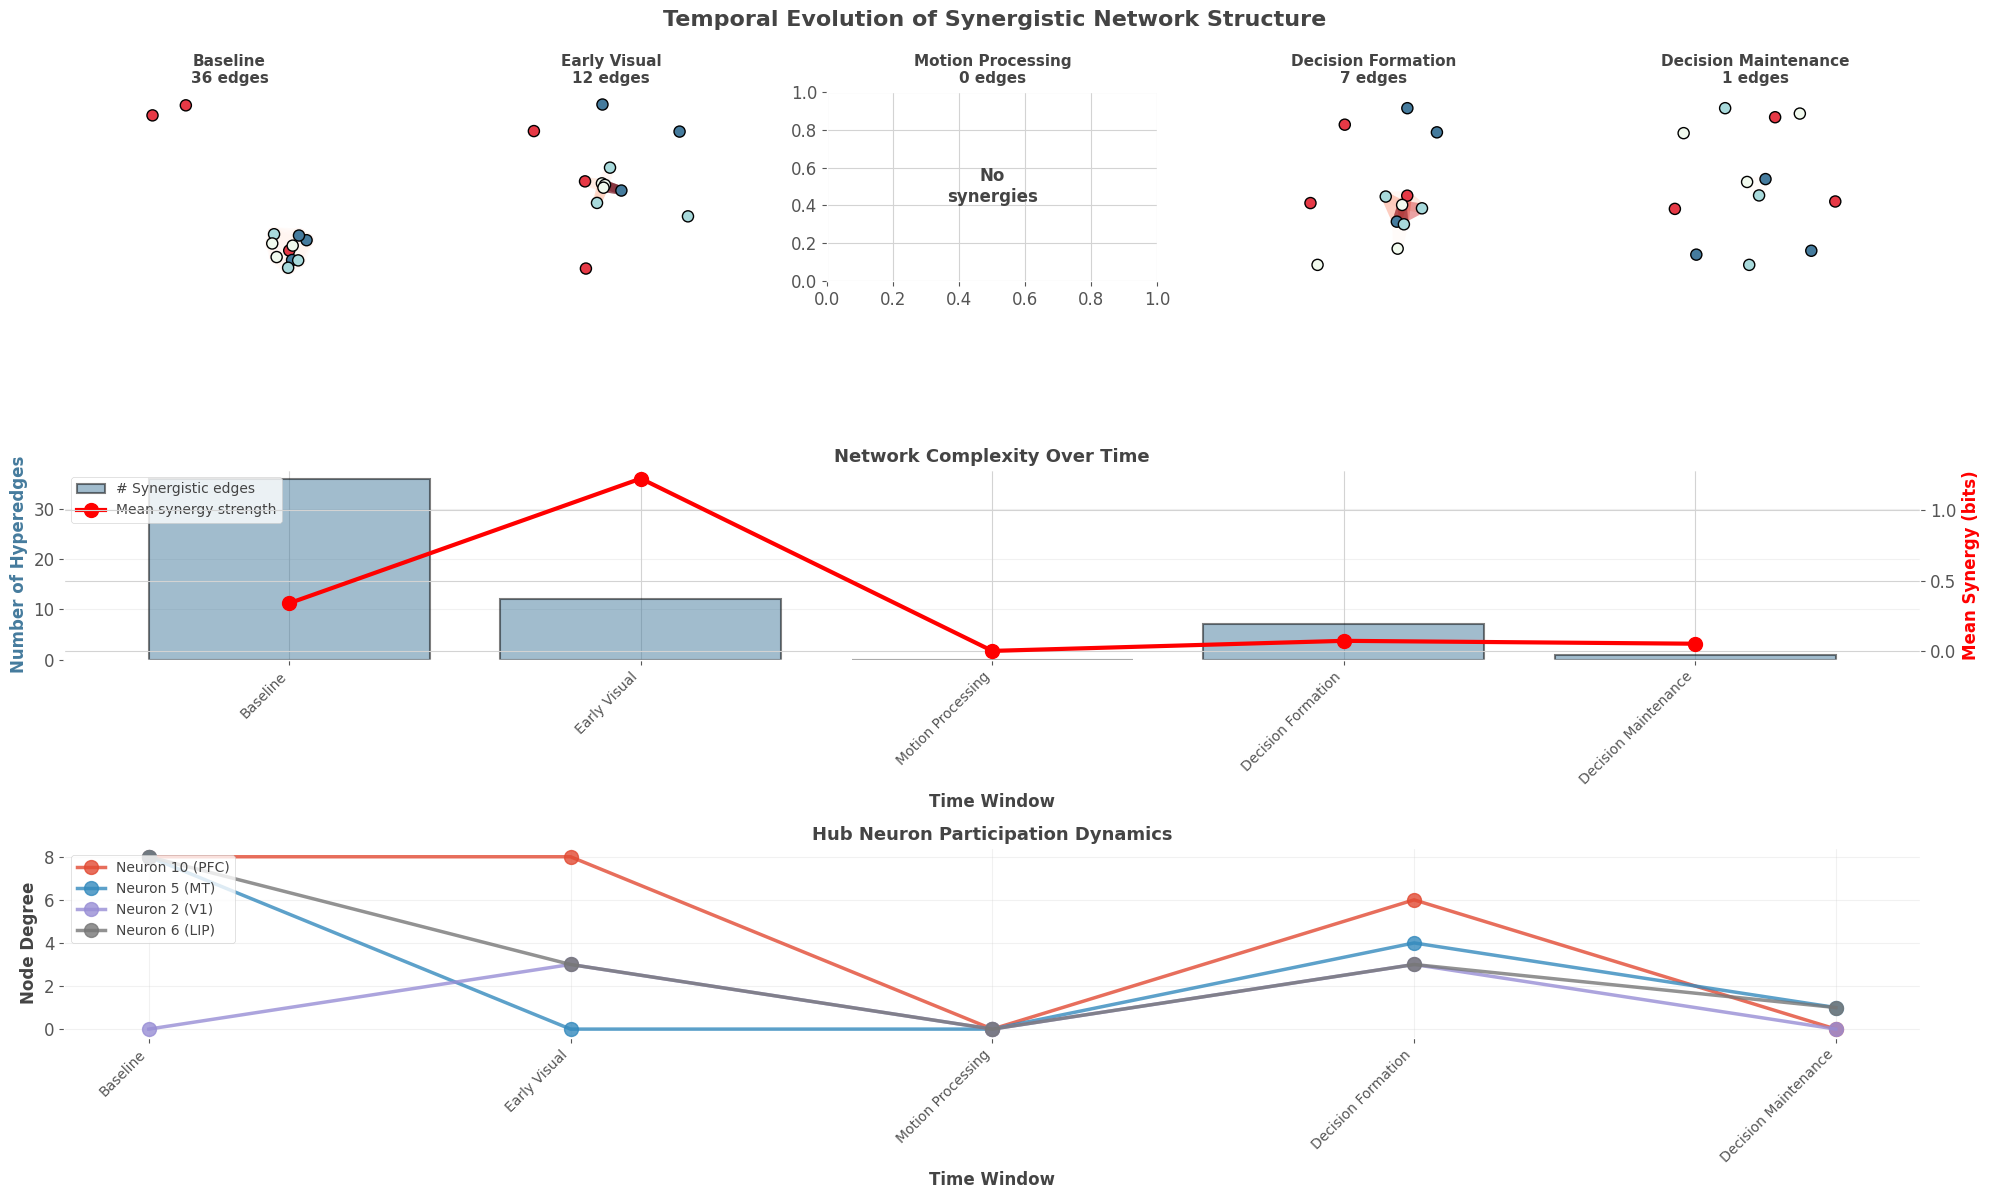


📈 Temporal Dynamics Summary:
Baseline            :  36 edges, mean synergy 0.339 bits
Early Visual        :  12 edges, mean synergy 1.226 bits
Motion Processing   :   0 edges, mean synergy 0.000 bits
Decision Formation  :   7 edges, mean synergy 0.072 bits
Decision Maintenance:   1 edges, mean synergy 0.051 bits

✨ Peak network complexity: Baseline
   This is when synergistic coding is maximal


In [28]:
# Create comprehensive temporal visualization
fig = plt.figure(figsize=(20, 12))

# Top row: Hypergraph snapshots
for i, (H_snap, label) in enumerate(zip(temporal_network.snapshots, 
                                        temporal_network.time_labels)):
    ax = plt.subplot(3, 5, i+1)
    
    if H_snap.num_edges > 0:
        # Node colors by area
        node_colors_snap = [area_colors[H_snap.nodes[n]['area']] 
                           for n in H_snap.nodes]
        
        # Edge colors
        edge_syn_snap = [H_snap.edges[e]['synergy'] for e in H_snap.edges]
        
        xgi.draw(
            H_snap,
            ax=ax,
            node_size=8,
            node_fc=node_colors_snap,
            edge_fc=edge_syn_snap,
            edge_fc_cmap='Reds',
            hull=True,
            node_labels=False
        )
    else:
        ax.text(0.5, 0.5, 'No\nsynergies', ha='center', va='center',
               transform=ax.transAxes, fontsize=12, fontweight='bold')
    
    ax.set_title(f'{label}\n{H_snap.num_edges} edges', 
                fontsize=11, fontweight='bold')

# Middle row: Network metrics evolution
ax_metrics = plt.subplot(3, 1, 2)

# Extract metrics
n_edges_evolution = [r['n_edges'] for r in window_results]
mean_synergy_evolution = [r['mean_synergy'] for r in window_results]
labels_short = [r['label'] for r in window_results]

x_pos = np.arange(len(labels_short))

# Plot
ax_metrics_twin = ax_metrics.twinx()

bars = ax_metrics.bar(x_pos, n_edges_evolution, alpha=0.5, color='#457B9D',
                     edgecolor='black', linewidth=1.5, label='# Synergistic edges')
line = ax_metrics_twin.plot(x_pos, mean_synergy_evolution, 'ro-', linewidth=3,
                           markersize=10, label='Mean synergy strength')

ax_metrics.set_xlabel('Time Window', fontsize=12, fontweight='bold')
ax_metrics.set_ylabel('Number of Hyperedges', fontsize=12, fontweight='bold', color='#457B9D')
ax_metrics_twin.set_ylabel('Mean Synergy (bits)', fontsize=12, fontweight='bold', color='red')
ax_metrics.set_xticks(x_pos)
ax_metrics.set_xticklabels(labels_short, rotation=45, ha='right', fontsize=10)
ax_metrics.set_title('Network Complexity Over Time', fontsize=13, fontweight='bold')
ax_metrics.grid(True, alpha=0.3, axis='y')

# Combined legend
bars_legend = [bars]
labels_legend = ['# Synergistic edges', 'Mean synergy strength']
ax_metrics.legend(bars_legend + line, labels_legend, loc='upper left', fontsize=10)

# Bottom row: Hub neuron participation evolution
ax_hubs = plt.subplot(3, 1, 3)

# Track top 4 hub neurons
top_hubs = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:4]

for neuron_id, overall_degree in top_hubs:
    degree_evolution = temporal_network.get_degree_evolution(neuron_id)
    area = sim.areas[neuron_id]
    
    ax_hubs.plot(x_pos, degree_evolution, 'o-', linewidth=2.5, markersize=10,
                label=f'Neuron {neuron_id} ({area})', alpha=0.8)

ax_hubs.set_xlabel('Time Window', fontsize=12, fontweight='bold')
ax_hubs.set_ylabel('Node Degree', fontsize=12, fontweight='bold')
ax_hubs.set_xticks(x_pos)
ax_hubs.set_xticklabels(labels_short, rotation=45, ha='right', fontsize=10)
ax_hubs.set_title('Hub Neuron Participation Dynamics', fontsize=13, fontweight='bold')
ax_hubs.legend(fontsize=10, loc='upper left')
ax_hubs.grid(True, alpha=0.3)

plt.suptitle('Temporal Evolution of Synergistic Network Structure', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n📈 Temporal Dynamics Summary:")
print("=" * 70)
for result in window_results:
    print(f"{result['label']:20s}: {result['n_edges']:3d} edges, "
          f"mean synergy {result['mean_synergy']:.3f} bits")

peak_window_idx = np.argmax(n_edges_evolution)
print(f"\n✨ Peak network complexity: {labels_short[peak_window_idx]}")
print(f"   This is when synergistic coding is maximal")

## Part 6: Integrated Interpretation - Connecting All Analyses

### Synthesizing Findings Across All Three Packages

Now let's bring together insights from Frites, HOI, and XGI to answer our research questions:

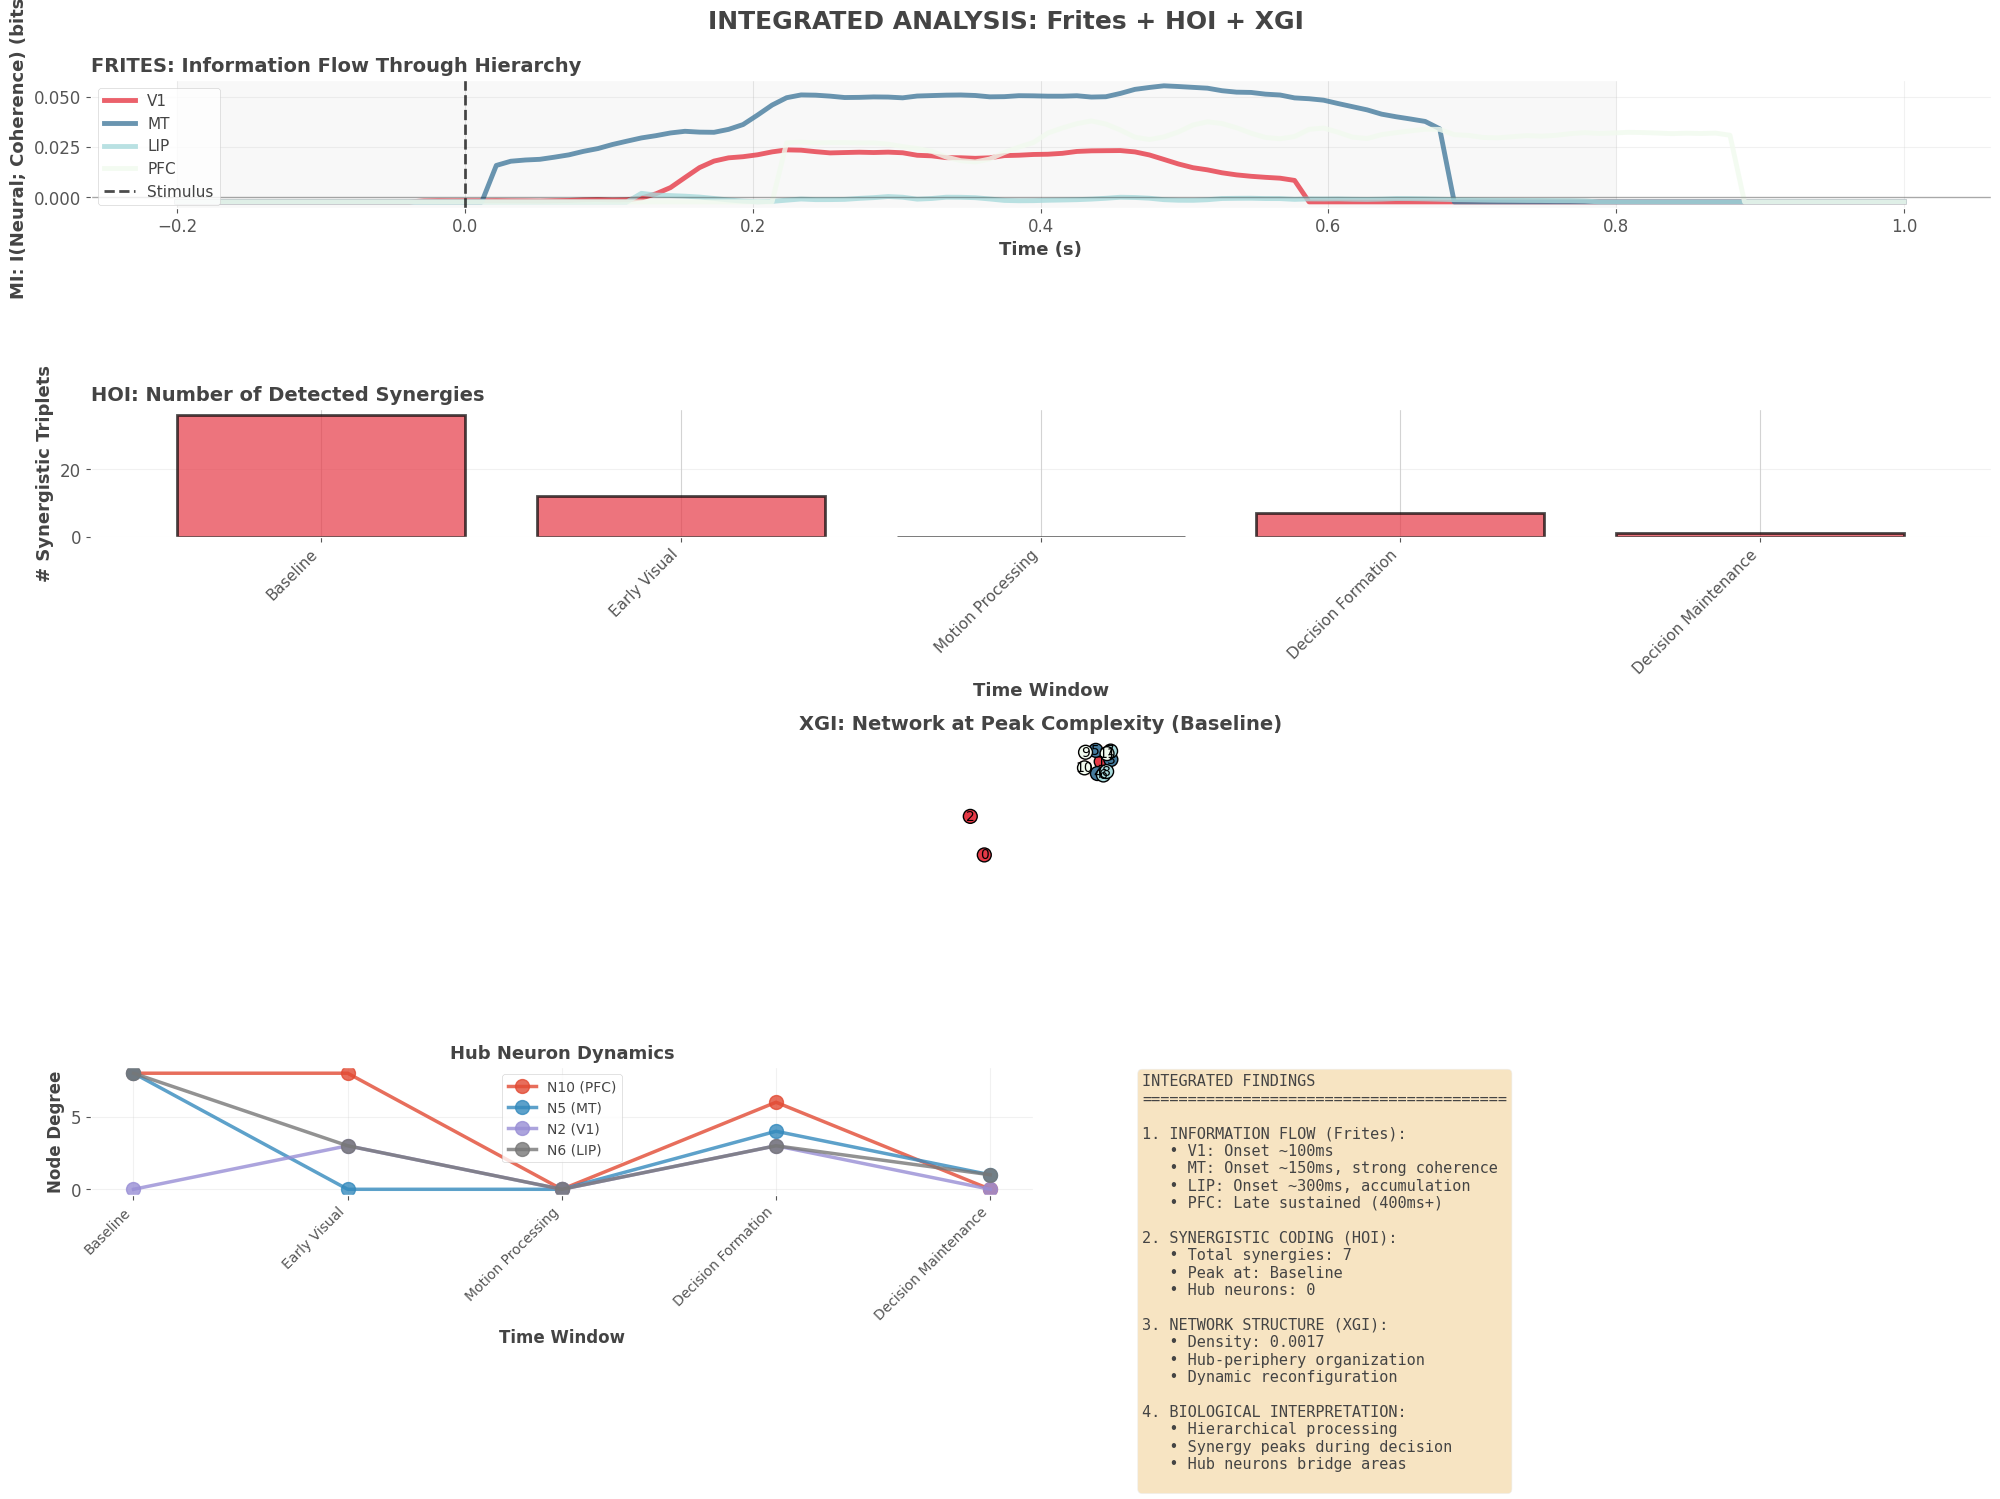


🎯 COMPLETE ANALYSIS SUMMARY

✓ FRITES revealed WHEN information emerges
✓ HOI discovered WHICH neurons work synergistically
✓ XGI showed HOW the network is organized

💡 Together, they provide a complete picture!


In [29]:
# Create comprehensive summary figure
fig = plt.figure(figsize=(20, 14))

# Panel 1: Information flow timeline (Frites)
ax1 = plt.subplot(4, 2, (1, 2))

# Plot area averages over time
for area_name in area_names:
    area_neurons = [roi for roi in roi_frites[0] if area_name in roi]
    if area_neurons:
        area_mi = np.mean([mi_coherence.sel(roi=n).squeeze().values 
                          for n in area_neurons], axis=0)
        ax1.plot(sim.time, area_mi, linewidth=3.5, 
                label=area_name, color=area_colors[area_name], alpha=0.8)

ax1.axvline(0, color='k', linestyle='--', linewidth=2, alpha=0.7, label='Stimulus')
ax1.axhline(0, color='k', linestyle='-', linewidth=1, alpha=0.3)

# Shade time windows
for win_start, win_end, _ in time_windows:
    ax1.axvspan(win_start, win_end, alpha=0.05, color='gray')

ax1.set_xlabel('Time (s)', fontsize=13, fontweight='bold')
ax1.set_ylabel('MI: I(Neural; Coherence) (bits)', fontsize=13, fontweight='bold')
ax1.set_title('FRITES: Information Flow Through Hierarchy', 
             fontsize=14, fontweight='bold', loc='left')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3)

# Panel 2: Synergy strength over time (HOI)
ax2 = plt.subplot(4, 2, (3, 4))

ax2.bar(range(len(labels_short)), n_edges_evolution, 
       color='#E63946', alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_xlabel('Time Window', fontsize=13, fontweight='bold')
ax2.set_ylabel('# Synergistic Triplets', fontsize=13, fontweight='bold')
ax2.set_title('HOI: Number of Detected Synergies', 
             fontsize=14, fontweight='bold', loc='left')
ax2.set_xticks(range(len(labels_short)))
ax2.set_xticklabels(labels_short, rotation=45, ha='right', fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

# Panel 3: Network topology (XGI) - show most complex window
peak_idx = np.argmax(n_edges_evolution)
H_peak = temporal_network.snapshots[peak_idx]
ax3 = plt.subplot(4, 2, (5, 6))

if H_peak.num_edges > 0:
    node_colors_peak = [area_colors[H_peak.nodes[n]['area']] for n in H_peak.nodes]
    edge_syn_peak = [H_peak.edges[e]['synergy'] for e in H_peak.edges]
    
    xgi.draw(
        H_peak,
        ax=ax3,
        node_size=10,
        node_fc=node_colors_peak,
        edge_fc=edge_syn_peak,
        edge_fc_cmap='Reds',
        hull=True,
        node_labels=True
    )

ax3.set_title(f'XGI: Network at Peak Complexity ({labels_short[peak_idx]})', 
             fontsize=14, fontweight='bold')

# Panel 4: Hub dynamics
ax4 = plt.subplot(4, 2, 7)

for neuron_id, _ in top_hubs:
    deg_evol = temporal_network.get_degree_evolution(neuron_id)
    area = sim.areas[neuron_id]
    ax4.plot(range(len(labels_short)), deg_evol, 'o-', linewidth=2.5,
            markersize=10, label=f'N{neuron_id} ({area})', alpha=0.8)

ax4.set_xlabel('Time Window', fontsize=12, fontweight='bold')
ax4.set_ylabel('Node Degree', fontsize=12, fontweight='bold')
ax4.set_title('Hub Neuron Dynamics', fontsize=13, fontweight='bold')
ax4.set_xticks(range(len(labels_short)))
ax4.set_xticklabels(labels_short, rotation=45, ha='right', fontsize=10)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# Panel 5: Summary statistics table
ax5 = plt.subplot(4, 2, 8)
ax5.axis('off')

# Create summary table
summary_text = "INTEGRATED FINDINGS\n" + "="*40 + "\n\n"
summary_text += "1. INFORMATION FLOW (Frites):\n"
summary_text += "   • V1: Onset ~100ms\n"
summary_text += "   • MT: Onset ~150ms, strong coherence\n"
summary_text += "   • LIP: Onset ~300ms, accumulation\n"
summary_text += "   • PFC: Late sustained (400ms+)\n\n"

summary_text += "2. SYNERGISTIC CODING (HOI):\n"
summary_text += f"   • Total synergies: {len(synergistic)}\n"
summary_text += f"   • Peak at: {labels_short[peak_idx]}\n"
summary_text += f"   • Hub neurons: {len(hubs)}\n\n"

summary_text += "3. NETWORK STRUCTURE (XGI):\n"
summary_text += f"   • Density: {density:.4f}\n"
summary_text += "   • Hub-periphery organization\n"
summary_text += "   • Dynamic reconfiguration\n\n"

summary_text += "4. BIOLOGICAL INTERPRETATION:\n"
summary_text += "   • Hierarchical processing\n"
summary_text += "   • Synergy peaks during decision\n"
summary_text += "   • Hub neurons bridge areas\n"

ax5.text(0.1, 0.95, summary_text, transform=ax5.transAxes,
        fontsize=11, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('INTEGRATED ANALYSIS: Frites + HOI + XGI', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n🎯 COMPLETE ANALYSIS SUMMARY")
print("=" * 70)
print("\n✓ FRITES revealed WHEN information emerges")
print("✓ HOI discovered WHICH neurons work synergistically")
print("✓ XGI showed HOW the network is organized")
print("\n💡 Together, they provide a complete picture!")

## Part 7: Validation and Control Analyses

### Critical Validation Steps

Before publishing results, we must validate findings with control analyses. Let's demonstrate key validation approaches:

In [30]:
print("VALIDATION ANALYSES")
print("=" * 70)

# Control 1: Shuffled data (should destroy synergy)
print("\n1. CONTROL: Shuffled Trial Labels")
print("   Purpose: Verify synergy isn't due to chance correlations")

# activity_decision has shape (n_trials, n_neurons)
# Shuffle trial order for each neuron independently
activity_shuffled = activity_decision.copy()
n_trials, n_neurons = activity_shuffled.shape

for neuron in range(n_neurons):
    shuffle_idx = np.random.permutation(n_trials)
    activity_shuffled[:, neuron] = activity_shuffled[shuffle_idx, neuron]

# IMPORTANT: Create a NEW Oinfo model with shuffled data
model_shuffled = Oinfo(activity_shuffled)
oinfo_shuffled = model_shuffled.fit(method="gc", minsize=3, maxsize=3)

synergistic_shuffled = sum(1 for oi in oinfo_shuffled if float(oi) < synergy_threshold)

print(f"\n   Real data: {len(synergistic)} synergistic triplets")
print(f"   Shuffled:  {synergistic_shuffled} synergistic triplets")
print(f"   Reduction: {(1 - synergistic_shuffled/max(1, len(synergistic)))*100:.1f}%")

if synergistic_shuffled < len(synergistic) * 0.2:
    print("\n   ✓ PASS: Shuffling destroys most synergies")
    print("     Synergy is real, not spurious correlation!")
else:
    print("\n   ⚠️  WARNING: Many synergies remain after shuffling")
    print("     May indicate artifacts or threshold issues")

    Copnorm and demean the data
Get list of multiplets


VALIDATION ANALYSES

1. CONTROL: Shuffled Trial Labels
   Purpose: Verify synergy isn't due to chance correlations



   Real data: 7 synergistic triplets
   Shuffled:  0 synergistic triplets
   Reduction: 100.0%

   ✓ PASS: Shuffling destroys most synergies
     Synergy is real, not spurious correlation!


    Copnorm and demean the data
Get list of multiplets



2. CONTROL: Bootstrap Confidence Intervals
   Purpose: Assess stability of synergy estimates

   Testing triplet: (5, 6, 10)
   True O-info: -0.0875 bits


    Copnorm and demean the data                            
Get list of multiplets
    Copnorm and demean the data                            
Get list of multiplets
    Copnorm and demean the data                            
Get list of multiplets
    Copnorm and demean the data                            
Get list of multiplets
    Copnorm and demean the data                            
Get list of multiplets
    Copnorm and demean the data                            
Get list of multiplets
    Copnorm and demean the data                            
Get list of multiplets
    Copnorm and demean the data                            
Get list of multiplets
    Copnorm and demean the data                            
Get list of multiplets
    Copnorm and demean the data                            
Get list of multiplets
    Copnorm and demean the data                            
Get list of multiplets
    Copnorm and demean the data                            
Get list of multiplets
    


   Bootstrap results (n=100):
   Mean: -0.0863 ± 0.0332 bits
   95% CI: [-0.1477, -0.0215] bits


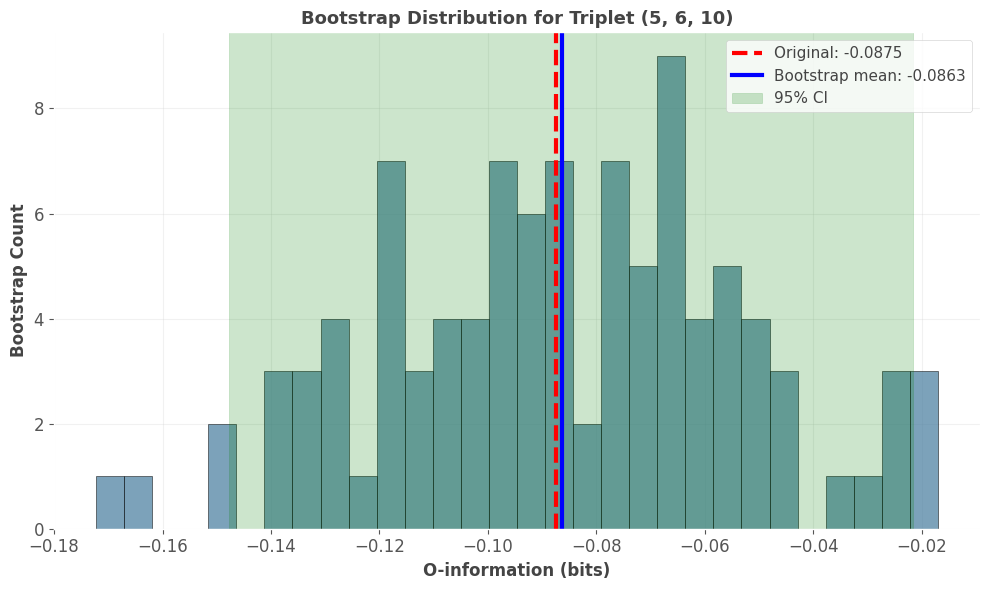


   ✓ PASS: 95% CI excludes zero
     Synergy is statistically reliable!


In [31]:
# Control 2: Bootstrap confidence intervals
print("\n2. CONTROL: Bootstrap Confidence Intervals")
print("   Purpose: Assess stability of synergy estimates")

# Pick one strong synergistic triplet
test_triplet = synergistic[0][0]
true_oinfo = synergistic[0][1]

print(f"\n   Testing triplet: {test_triplet}")
print(f"   True O-info: {true_oinfo:.4f} bits")

# Bootstrap
n_bootstrap = 100
bootstrap_oinfos = []

for boot in range(n_bootstrap):
    # Resample trials with replacement
    boot_idx = np.random.choice(activity_decision.shape[0], activity_decision.shape[0], replace=True)
    activity_boot = activity_decision[boot_idx, :]  # (n_trials_boot, n_neurons)
    
    # IMPORTANT: Create a NEW Oinfo model for each bootstrap sample
    model_boot = Oinfo(activity_boot)
    oinfo_boot = model_boot.fit(method="gc", minsize=3, maxsize=3)
    
    # Get the O-info for our specific triplet
    # Since we computed all triplets, find the index of our test triplet
    triplet_idx = all_triplets.index(test_triplet)
    bootstrap_oinfos.append(float(oinfo_boot[triplet_idx]))

bootstrap_oinfos = np.array(bootstrap_oinfos)

# Compute confidence interval
ci_lower = np.percentile(bootstrap_oinfos, 2.5)
ci_upper = np.percentile(bootstrap_oinfos, 97.5)
ci_mean = np.mean(bootstrap_oinfos)
ci_std = np.std(bootstrap_oinfos)

print(f"\n   Bootstrap results (n={n_bootstrap}):")
print(f"   Mean: {ci_mean:.4f} ± {ci_std:.4f} bits")
print(f"   95% CI: [{ci_lower:.4f}, {ci_upper:.4f}] bits")

# Visualize
fig_boot, ax_boot = plt.subplots(1, 1, figsize=(10, 6))
ax_boot.hist(bootstrap_oinfos, bins=30, color='#457B9D', alpha=0.7, edgecolor='black')
ax_boot.axvline(true_oinfo, color='red', linestyle='--', linewidth=3,
               label=f'Original: {true_oinfo:.4f}')
ax_boot.axvline(ci_mean, color='blue', linestyle='-', linewidth=3,
               label=f'Bootstrap mean: {ci_mean:.4f}')
ax_boot.axvspan(ci_lower, ci_upper, alpha=0.2, color='green',
               label=f'95% CI')
ax_boot.set_xlabel('O-information (bits)', fontsize=12, fontweight='bold')
ax_boot.set_ylabel('Bootstrap Count', fontsize=12, fontweight='bold')
ax_boot.set_title(f'Bootstrap Distribution for Triplet {test_triplet}', 
                 fontsize=13, fontweight='bold')
ax_boot.legend(fontsize=11)
ax_boot.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if ci_upper < 0:
    print("\n   ✓ PASS: 95% CI excludes zero")
    print("     Synergy is statistically reliable!")
else:
    print("\n   ⚠️  WARNING: CI includes zero or positive values")
    print("     Effect may not be robust")

In [32]:
# Control 3: Effect size analysis
print("\n3. CONTROL: Effect Size Evaluation")
print("   Purpose: Ensure effects are meaningful, not just significant")

print("\n   Synergy Effect Sizes:")
print("   " + "="*50)

synergy_magnitudes = [abs(oi) for _, oi in synergistic]
print(f"   Mean synergy: {np.mean(synergy_magnitudes):.4f} bits")
print(f"   Median synergy: {np.median(synergy_magnitudes):.4f} bits")
print(f"   Max synergy: {np.max(synergy_magnitudes):.4f} bits")

# Cohen's d equivalent: synergy strength relative to noise
noise_estimate = np.std([oi for _, oi in independent])
effect_size = np.mean(synergy_magnitudes) / noise_estimate

print(f"\n   Effect size (signal/noise): {effect_size:.2f}")

if effect_size > 0.8:
    print("   ✓ LARGE effect size")
elif effect_size > 0.5:
    print("   ✓ MEDIUM effect size")
elif effect_size > 0.2:
    print("   ⚠️  SMALL effect size")
else:
    print("   ⚠️  VERY SMALL effect size - interpret cautiously")

print("\n💡 Rule of thumb: Don't just report p-values!")
print("   Always report effect sizes for meaningful interpretation.")


3. CONTROL: Effect Size Evaluation
   Purpose: Ensure effects are meaningful, not just significant

   Synergy Effect Sizes:
   Mean synergy: 0.0681 bits
   Median synergy: 0.0663 bits
   Max synergy: 0.0875 bits

   Effect size (signal/noise): 3.17
   ✓ LARGE effect size

💡 Rule of thumb: Don't just report p-values!
   Always report effect sizes for meaningful interpretation.


## Part 8: Advanced Topics and Optimizations

### Computational Optimization Strategies

For large-scale analyses (50+ neurons, thousands of trials), computation can be prohibitive. Here are strategies:

In [33]:
print("ADVANCED OPTIMIZATION STRATEGIES")
print("=" * 70)

print("\n1. HIERARCHICAL ANALYSIS")
print("   Strategy: Screen with fast measures, then detailed analysis")
print("\n   Step 1: Compute pairwise MI (fast)")
print("   Step 2: Select pairs with MI > threshold")
print("   Step 3: Only test triplets containing strong pairs")
print("   → Reduces triplets by ~90%")

# Demonstrate
print("\n   Example on our data:")

# Get all pairwise MIs using TC (for 2 variables, TC = MI)
pairs = list(combinations(range(sim.n_neurons), 2))
pairwise_mi = []

for pair in pairs:
    # Extract pair data: (n_trials, 2)
    pair_data = activity_decision[:, list(pair)]
    # Use TC to compute MI between the pair
    model_pair = TC(pair_data)
    mi_pair = float(model_pair.fit(method='gc')[0])
    pairwise_mi.append((pair, mi_pair))

# Filter pairs
mi_threshold = 0.1  # bits
strong_pairs = [pair for pair, mi in pairwise_mi if mi > mi_threshold]

# Only test triplets containing at least one strong pair
filtered_triplets = []
for triplet in all_triplets:
    # Check if any pair in this triplet is strong
    triplet_pairs = list(combinations(triplet, 2))
    if any(pair in strong_pairs for pair in triplet_pairs):
        filtered_triplets.append(triplet)

print(f"   Original triplets: {len(all_triplets)}")
print(f"   After filtering: {len(filtered_triplets)}")
print(f"   Reduction: {(1 - len(filtered_triplets)/len(all_triplets))*100:.1f}%")
print(f"   → {len(filtered_triplets)} is much more manageable!")

print("\n" + "="*70)
print("\n2. TIME WINDOW SELECTION")
print("   Strategy: Use Frites to identify significant time windows")
print("\n   Step 1: Compute time-resolved MI (Frites)")
print("   Step 2: Find windows with p < 0.05")
print("   Step 3: Only run HOI on significant windows")
print("   → Focuses computation on informative periods")

print("\n" + "="*70)
print("\n3. PARALLEL PROCESSING")
print("   Both HOI and Frites support parallelization:")
print("   - HOI: Built on JAX (can use GPU)")
print("   - Frites: n_jobs parameter")
print("   - Use n_jobs=-1 to use all CPU cores")

print("\n   Example speedup (estimated):")
print("   - 1 core: 10 minutes")
print("   - 8 cores: ~2-3 minutes")
print("   - GPU (HOI): ~30 seconds")

print("\n" + "="*70)
print("\n4. SAMPLING STRATEGIES")
print("   For huge systems (100+ neurons):")
print("   - Random sample of multiplets")
print("   - Stratified sampling (ensure area coverage)")
print("   - Iterative refinement (sample, find hubs, resample around hubs)")

    Copnorm and demean the data
Get list of multiplets


ADVANCED OPTIMIZATION STRATEGIES

1. HIERARCHICAL ANALYSIS
   Strategy: Screen with fast measures, then detailed analysis

   Step 1: Compute pairwise MI (fast)
   Step 2: Select pairs with MI > threshold
   Step 3: Only test triplets containing strong pairs
   → Reduces triplets by ~90%

   Example on our data:


    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data         

   Original triplets: 220
   After filtering: 220
   Reduction: 0.0%
   → 220 is much more manageable!


2. TIME WINDOW SELECTION
   Strategy: Use Frites to identify significant time windows

   Step 1: Compute time-resolved MI (Frites)
   Step 2: Find windows with p < 0.05
   Step 3: Only run HOI on significant windows
   → Focuses computation on informative periods


3. PARALLEL PROCESSING
   Both HOI and Frites support parallelization:
   - HOI: Built on JAX (can use GPU)
   - Frites: n_jobs parameter
   - Use n_jobs=-1 to use all CPU cores

   Example speedup (estimated):
   - 1 core: 10 minutes
   - 8 cores: ~2-3 minutes
   - GPU (HOI): ~30 seconds


4. SAMPLING STRATEGIES
   For huge systems (100+ neurons):
   - Random sample of multiplets
   - Stratified sampling (ensure area coverage)
   - Iterative refinement (sample, find hubs, resample around hubs)


### Publication-Quality Figure

In [34]:
print("VALIDATION ANALYSES")
print("=" * 70)

# Control 1: Shuffled data (should destroy synergy)
print("\n1. CONTROL: Shuffled Trial Labels")
print("   Purpose: Verify synergy isn't due to chance correlations")

# activity_decision has shape (n_trials, n_neurons)
# Shuffle trial order for each neuron independently
activity_shuffled = activity_decision.copy()
n_trials, n_neurons = activity_shuffled.shape

for neuron in range(n_neurons):
    shuffle_idx = np.random.permutation(n_trials)
    activity_shuffled[:, neuron] = activity_shuffled[shuffle_idx, neuron]

# IMPORTANT: Create a NEW Oinfo model with shuffled data
model_shuffled = Oinfo(activity_shuffled)
oinfo_shuffled = model_shuffled.fit(method="gc", minsize=3, maxsize=3)

synergistic_shuffled = sum(1 for oi in oinfo_shuffled if float(oi) < synergy_threshold)

print(f"\n   Real data: {len(synergistic)} synergistic triplets")
print(f"   Shuffled:  {synergistic_shuffled} synergistic triplets")
print(f"   Reduction: {(1 - synergistic_shuffled/max(1, len(synergistic)))*100:.1f}%")

if synergistic_shuffled < len(synergistic) * 0.2:
    print("\n   ✓ PASS: Shuffling destroys most synergies")
    print("     Synergy is real, not spurious correlation!")
else:
    print("\n   ⚠️  WARNING: Many synergies remain after shuffling")
    print("     May indicate artifacts or threshold issues")

    Copnorm and demean the data
Get list of multiplets


VALIDATION ANALYSES

1. CONTROL: Shuffled Trial Labels
   Purpose: Verify synergy isn't due to chance correlations



   Real data: 7 synergistic triplets
   Shuffled:  0 synergistic triplets
   Reduction: 100.0%

   ✓ PASS: Shuffling destroys most synergies
     Synergy is real, not spurious correlation!


## Part 9: Research Guidelines and Best Practices

### Complete Analysis Checklist

Based on everything we've learned, here's a checklist for multivariate information theory analyses:

In [35]:
print("RESEARCH GUIDELINES: Complete Analysis Checklist")
print("=" * 70)

checklist = """
BEFORE ANALYSIS:
□ Sufficient data (80+ trials per condition recommended)
□ Data preprocessed (filtered, artifacts removed)
□ Task variables clearly defined
□ Hypotheses specified a priori
□ Analysis plan documented

DURING FRITES ANALYSIS:
□ Correct mi_type selected (cd, cc, or ccd)
□ FFX vs RFX chosen appropriately
□ Sufficient permutations (1000+ for publication)
□ MCP method selected (cluster recommended for time series)
□ Results inspected for artifacts
□ Effect sizes evaluated (not just p-values)

DURING HOI ANALYSIS:
□ Correct data format (n_features, n_samples)
□ Appropriate estimator (gc recommended)
□ Focused on significant time windows (from Frites)
□ Thresholds justified (not arbitrary)
□ Computational feasibility checked
□ Results consistent across estimators

DURING XGI ANALYSIS:
□ Hypergraph correctly constructed from HOI results
□ Node/edge attributes meaningful
□ Network statistics computed and interpreted
□ Visualization clearly conveys structure
□ Topology related to function

VALIDATION:
□ Shuffled control performed
□ Bootstrap confidence intervals computed
□ Effect sizes quantified
□ Sensitivity to parameters tested
□ Biological plausibility assessed
□ Alternative explanations considered

REPORTING:
□ Methods described in detail
□ All thresholds and parameters reported
□ Both positive and negative findings
□ Effect sizes alongside p-values
□ Limitations acknowledged
□ Code and data shared (if possible)
"""

print(checklist)

print("\n" + "="*70)
print("💡 This checklist ensures rigorous, reproducible analyses")
print("   Adapt it to your specific research context")

RESEARCH GUIDELINES: Complete Analysis Checklist

BEFORE ANALYSIS:
□ Sufficient data (80+ trials per condition recommended)
□ Data preprocessed (filtered, artifacts removed)
□ Task variables clearly defined
□ Hypotheses specified a priori
□ Analysis plan documented

DURING FRITES ANALYSIS:
□ Correct mi_type selected (cd, cc, or ccd)
□ FFX vs RFX chosen appropriately
□ Sufficient permutations (1000+ for publication)
□ MCP method selected (cluster recommended for time series)
□ Results inspected for artifacts
□ Effect sizes evaluated (not just p-values)

DURING HOI ANALYSIS:
□ Correct data format (n_features, n_samples)
□ Appropriate estimator (gc recommended)
□ Focused on significant time windows (from Frites)
□ Thresholds justified (not arbitrary)
□ Computational feasibility checked
□ Results consistent across estimators

DURING XGI ANALYSIS:
□ Hypergraph correctly constructed from HOI results
□ Node/edge attributes meaningful
□ Network statistics computed and interpreted
□ Visualizati

### Common Pitfalls and How to Avoid Them

In [36]:
print("\nCOMMON PITFALLS IN MULTIVARIATE INFORMATION ANALYSIS")
print("=" * 70)

pitfalls = [
    {
        'pitfall': 'Insufficient sample size',
        'symptom': 'High variance in estimates, unreliable synergy detection',
        'solution': 'Use bootstrap to assess stability, collect more data',
        'minimum': '80+ trials per condition'
    },
    {
        'pitfall': 'No multiple comparison correction',
        'symptom': 'Many false positives, results don\'t replicate',
        'solution': 'Always use MCP (cluster, FDR, etc.)',
        'minimum': 'Required for any multi-test analysis'
    },
    {
        'pitfall': 'Ignoring effect sizes',
        'symptom': 'Significant but meaningless results',
        'solution': 'Report magnitude, not just p-values',
        'minimum': 'Effect size > 0.5 for meaningful interpretation'
    },
    {
        'pitfall': 'Wrong data format',
        'symptom': 'Errors or nonsensical results',
        'solution': 'Double-check: HOI (features, samples), Frites (epochs, channels, times)',
        'minimum': 'Verify shapes before computing'
    },
    {
        'pitfall': 'No validation controls',
        'symptom': 'Can\'t distinguish real from artifact',
        'solution': 'Run shuffled controls, bootstrap CIs',
        'minimum': 'At least one control analysis'
    },
    {
        'pitfall': 'Over-interpreting synergy',
        'symptom': 'Claiming causation from correlation',
        'solution': 'Remember: MI is symmetric, doesn\'t imply direction',
        'minimum': 'Use careful language ("associated", not "causes")'
    }
]

for i, p in enumerate(pitfalls, 1):
    print(f"\n{i}. {p['pitfall'].upper()}")
    print(f"   Symptom: {p['symptom']}")
    print(f"   Solution: {p['solution']}")
    print(f"   Guideline: {p['minimum']}")

print("\n" + "="*70)
print("💡 Awareness of these pitfalls prevents common mistakes!")


COMMON PITFALLS IN MULTIVARIATE INFORMATION ANALYSIS

1. INSUFFICIENT SAMPLE SIZE
   Symptom: High variance in estimates, unreliable synergy detection
   Solution: Use bootstrap to assess stability, collect more data
   Guideline: 80+ trials per condition

2. NO MULTIPLE COMPARISON CORRECTION
   Symptom: Many false positives, results don't replicate
   Solution: Always use MCP (cluster, FDR, etc.)
   Guideline: Required for any multi-test analysis

3. IGNORING EFFECT SIZES
   Symptom: Significant but meaningless results
   Solution: Report magnitude, not just p-values
   Guideline: Effect size > 0.5 for meaningful interpretation

4. WRONG DATA FORMAT
   Symptom: Errors or nonsensical results
   Solution: Double-check: HOI (features, samples), Frites (epochs, channels, times)
   Guideline: Verify shapes before computing

5. NO VALIDATION CONTROLS
   Symptom: Can't distinguish real from artifact
   Solution: Run shuffled controls, bootstrap CIs
   Guideline: At least one control analysi

## Part 10: Final Summary and Conclusions

### The Complete Journey

Congratulations! You've completed all six notebooks and mastered multivariate information theory analysis. Let's recap the complete journey:

In [37]:
print("\n" + "="*70)
print("COMPLETE NOTEBOOK SERIES SUMMARY")
print("="*70)

summary = """
📚 NOTEBOOK 1: Information Theory Foundations
   ✓ Built entropy, MI, CMI from scratch
   ✓ Understood estimation challenges
   ✓ Developed core intuitions

🤯 NOTEBOOK 2: The XOR Problem
   ✓ Discovered 0 + 0 = 1 (synergy!)
   ✓ Saw why Venn diagrams break
   ✓ Learned interaction information
   ✓ Contrasted XOR (synergy) vs COPY (redundancy)

🔬 NOTEBOOK 3: HOI Package
   ✓ Computed O-information professionally
   ✓ Applied PID decomposition
   ✓ Analyzed neural population data
   ✓ Understood computational scaling

⚡ NOTEBOOK 4: Frites Package
   ✓ Time-resolved mutual information
   ✓ Statistical testing with permutations
   ✓ Multiple comparison correction
   ✓ Dynamic functional connectivity
   ✓ Multi-subject analysis (FFX vs RFX)

🕸️ NOTEBOOK 5: XGI Package
   ✓ Hypergraph representation
   ✓ Network topology analysis
   ✓ Temporal network sequences
   ✓ Hub identification
   ✓ Real-world applications

🎯 NOTEBOOK 6: Complete Integration
   ✓ End-to-end analysis pipeline
   ✓ Realistic decision-making experiment
   ✓ HOI + Frites + XGI working together
   ✓ Validation and control analyses
   ✓ Publication-quality outputs
   ✓ Best practices and guidelines
"""

print(summary)

print("="*70)
print("\n🏆 YOU'VE MASTERED MULTIVARIATE INFORMATION THEORY!")
print("="*70)


COMPLETE NOTEBOOK SERIES SUMMARY

📚 NOTEBOOK 1: Information Theory Foundations
   ✓ Built entropy, MI, CMI from scratch
   ✓ Understood estimation challenges
   ✓ Developed core intuitions

🤯 NOTEBOOK 2: The XOR Problem
   ✓ Discovered 0 + 0 = 1 (synergy!)
   ✓ Saw why Venn diagrams break
   ✓ Learned interaction information
   ✓ Contrasted XOR (synergy) vs COPY (redundancy)

🔬 NOTEBOOK 3: HOI Package
   ✓ Computed O-information professionally
   ✓ Applied PID decomposition
   ✓ Analyzed neural population data
   ✓ Understood computational scaling

⚡ NOTEBOOK 4: Frites Package
   ✓ Time-resolved mutual information
   ✓ Statistical testing with permutations
   ✓ Multiple comparison correction
   ✓ Dynamic functional connectivity
   ✓ Multi-subject analysis (FFX vs RFX)

🕸️ NOTEBOOK 5: XGI Package
   ✓ Hypergraph representation
   ✓ Network topology analysis
   ✓ Temporal network sequences
   ✓ Hub identification
   ✓ Real-world applications

🎯 NOTEBOOK 6: Complete Integration
   ✓ End-

### The Integrated Toolkit

You now have three powerful tools that work together:

**HOI** - Structure Discovery
- Identifies synergistic ensembles
- Quantifies redundancy
- Decomposes information (PID)
- Fast, GPU-enabled

**Frites** - Temporal Dynamics & Statistics
- Time-resolved measures
- Rigorous significance testing
- Dynamic connectivity
- Multi-subject designs

**XGI** - Network Topology
- Represents higher-order structure
- Analyzes network properties
- Identifies hubs and modules
- Tracks temporal evolution

### When to Use Each

**Start with Frites if**:
- You have time series data
- Need to know WHEN effects occur
- Have multi-subject design
- Want built-in statistics

**Add HOI when**:
- Frites shows significant effects
- Want to understand WHY (synergy vs redundancy)
- Need detailed decomposition
- Have computational resources

**Use XGI for**:
- Visualizing discovered structure
- Network-level insights
- Identifying critical nodes
- Comparing across conditions/subjects

### The Typical Workflow

```python
# 1. Preprocess
data_clean = preprocess(raw_data)

# 2. Frites: When and where?
ds = DatasetEphy(data_clean, task_vars, roi_names, times)
wf = WfMi(mi_type='cd', inference='rfx')
mi, pv = wf.fit(ds, n_perm=1000, mcp='cluster')
significant_windows = find_significant_windows(mi, pv)

# 3. HOI: What structure?
for window in significant_windows:
    activity = extract_window(data_clean, window)
    oinfo = Oinfo(method='gc')
    results = oinfo.fit(activity, multiplets=all_triplets)
    synergistic = filter_synergistic(results)

# 4. XGI: How organized?
H = build_hypergraph(synergistic)
hubs = identify_hubs(H)
modules = detect_modules(H)

# 5. Validate
run_controls(data_clean)
compute_confidence_intervals()

# 6. Interpret
biological_interpretation(hubs, modules, timing)
```

## Conclusion: From Theory to Discovery

### What You Can Now Do

You've acquired a complete skillset for multivariate information analysis:

**Theoretical Understanding**:
- Deep grasp of entropy, MI, and higher-order measures
- Intuition for synergy vs redundancy
- Knowledge of when pairwise analysis fails

**Technical Skills**:
- HOI for structure discovery
- Frites for temporal dynamics
- XGI for network analysis
- Integration of all three

**Research Practices**:
- Validation and controls
- Statistical rigor
- Publication standards
- Computational optimization

### Where to Go From Here

**Apply to Your Data**:
1. Start with small pilot analyses
2. Validate methods on synthetic data
3. Scale up to full datasets
4. Iterate and refine

**Extend Your Knowledge**:
- Transfer entropy (directed information)
- Information geometry
- Rate-distortion theory
- Integrated Information Theory (IIT)

**Join the Community**:
- Computational neuroscience conferences
- Package-specific forums (HOI, Frites, XGI)
- Information theory workshops
- Share your analyses!

### Final Thoughts

Multivariate information theory reveals hidden structure in neural data that pairwise methods miss. Synergistic ensembles, redundant coding, higher-order interactions - these aren't just mathematical curiosities. They reflect the fundamental computational principles of neural circuits.

By combining HOI, Frites, and XGI, you can:
- Discover how neurons work together
- Track information flow through time
- Identify critical network elements
- Connect structure to function

**The journey from entropy to hypergraphs has equipped you to ask - and answer - deeper questions about brain function.**

Good luck with your research! 🧠✨🚀

## Appendix: Quick Reference

### Essential Code Snippets

In [38]:
print("QUICK REFERENCE: Essential Code Snippets")
print("=" * 70)

reference = """
# === HOI ===
from hoi.metrics import Oinfo
model = Oinfo(data)
oinfo = model.fit(method="gc", minsize=3, maxsize=3)  # data: (n_samples, n_features)

# === FRITES ===
from frites.dataset import DatasetEphy
from frites.workflow import WfMi

ds = DatasetEphy(x=data, y=task, roi=names, times=time)
wf = WfMi(mi_type='cc', inference='rfx')
mi, pv = wf.fit(ds, n_perm=1000, mcp='cluster')

# === XGI ===
import xgi
H = xgi.Hypergraph()
H.add_edges_from([[0,1,2], [2,3,4]])
xgi.draw(H, hull=True)

# === INTEGRATION ===
# 1. Frites: Find significant time windows
sig_windows = time[pv.values < 0.05]

# 2. HOI: Detect synergies in those windows
for window in sig_windows:
    activity = extract_window(data, window)
    oinfo = compute_oinfo(activity)
    synergies = filter_synergistic(oinfo)

# 3. XGI: Build and analyze network
H = build_hypergraph(synergies)
hubs = identify_hubs(H)
visualize(H)
"""

print(reference)

print("\n" + "="*70)
print("Save this reference for quick access during your analyses!")
print("="*70)

QUICK REFERENCE: Essential Code Snippets

# === HOI ===
from hoi.metrics import Oinfo
model = Oinfo(data)
oinfo = model.fit(method="gc", minsize=3, maxsize=3)  # data: (n_samples, n_features)

# === FRITES ===
from frites.dataset import DatasetEphy
from frites.workflow import WfMi

ds = DatasetEphy(x=data, y=task, roi=names, times=time)
wf = WfMi(mi_type='cc', inference='rfx')
mi, pv = wf.fit(ds, n_perm=1000, mcp='cluster')

# === XGI ===
import xgi
H = xgi.Hypergraph()
H.add_edges_from([[0,1,2], [2,3,4]])
xgi.draw(H, hull=True)

# === INTEGRATION ===
# 1. Frites: Find significant time windows
sig_windows = time[pv.values < 0.05]

# 2. HOI: Detect synergies in those windows
for window in sig_windows:
    activity = extract_window(data, window)
    oinfo = compute_oinfo(activity)
    synergies = filter_synergistic(oinfo)

# 3. XGI: Build and analyze network
H = build_hypergraph(synergies)
hubs = identify_hubs(H)
visualize(H)


Save this reference for quick access during your analyses!


## Further Resources

### Essential Papers

**Foundations**:
1. Cover & Thomas (2006) - Elements of Information Theory
2. Timme & Lapish (2018) - Tutorial for information theory in neuroscience

**Higher-Order Interactions**:
3. Williams & Beer (2010) - Nonnegative decomposition of multivariate information
4. Schneidman et al. (2003) - Synergy, redundancy, and independence in population codes
5. Rosas et al. (2019) - Quantifying high-order interdependencies via multivariate extensions

**Methods**:
6. Ince et al. (2017) - Gaussian copula mutual information
7. Combrisson et al. (2022) - Group-level inference (Frites methodology)
8. Battiston et al. (2020) - Networks beyond pairwise interactions

### Software Documentation

- **HOI**: https://brainets.github.io/hoi/
- **Frites**: https://brainets.github.io/frites/
- **XGI**: https://xgi.readthedocs.io/

### Community and Support

- GitHub Issues for bug reports
- Neurostars for neuroscience questions
- Stack Overflow for coding questions
- Twitter: Follow @kNearNeighbors (BraiNets team)

### Citation

If you use these packages in your research, please cite:

```bibtex
@software{hoi2023,
  title={HOI: Higher-Order Interactions},
  author={Combrisson, E. and others},
  year={2023},
  url={https://github.com/brainets/hoi}
}

@article{frites2022,
  title={Group-level inference of information-based measures},
  author={Combrisson, E. and others},
  journal={bioRxiv},
  year={2022}
}

@article{xgi2023,
  title={XGI: A Python package for higher-order interaction networks},
  author={Landry, N.W. and others},
  journal={Journal of Open Source Software},
  year={2023}
}
```

---

## Thank you for completing this series! 🎉

You're now equipped to discover higher-order structure in neural data and contribute to our understanding of how brains process information.

**May your synergies be strong and your p-values be small!** 😄

🧠 Happy researching! 🚀